### This notebook presents code to accompany the paper

# A flexible data and knowledge-driven method for identifying climate drivers to predict summer conditions in China’s Northeast Farming Region 

In this work we collect around 30 different Climate Indexs, information on these can be found in `data/` read me file. To simplify the processing of all these seperate data files into one CSV, this has been done for you. The reason this has been left out is they are many different ways to process CSV files, we have used a combination of R and python for this and multiple people have been apart of this project. The format you're aiming for is seen below under `head(climate_indices)`. The dots actually get replaced with dashes so the column headers have the format `climate_index-month`. The other thing to watch out for here is the years, for example using a climate index in December 1981 to predict summer temperature 1981 doesn't make sense, as the summer comes first. Therefore we shifted this data, keeping everything in yearly rows for a simpler format. For example below when you see `wpsh-9` in the 1981 row, this is actually the WPSH in November 1980. Think of the index as the year we are looking to predict, that row contains climate indexs of the correct year to predict the year in the row index. 

This notebook contains all the nessacary methods to conduct this method:

### Section 1: Final Processing steps

* Standardising and detrending data 

### Section 2: Feature selection 

* Remove all features that are very poorly correlated with temperature or precip
* Run the rest through the random forest to find the most useful features 

### Section 3: Feature Refinement  

* Creating Bayseian Networks between selected Jets and Indices 
    
### Section 4 (not in this notebook): Dynamics Visualisation 
* See `./Dynamics/`

### Section 5: Creating predictive models 

* Linear Regression

## Section 1: Final Processing Steps 

* Standardising and detrending 

#### Detrending 

Firstly we detrend our data with a linear model. This ensures our data is stationary. We do this because of things like climate change, you can imagine that the temperature in NE has had an upward trend over the last 40 years or so. Detrending removes these trends so they are flat. 

#### Standardising 

Secondly we standardise our data, this sets the `mean = 0, standard deviation = 1` for each variable

In [76]:
temp_jja_fname = '../data/csv/temp_jja_NE_china.csv'
temp_jja = read.csv(paste(temp_jja_fname, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

In [77]:
climate_indices_fname = '../data/csv/joined_climate_indicies.csv'
climate_indices = read.csv(paste(climate_indices_fname, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

* Using `head()` to view the first 5 rows of our dataframe 

In [78]:
head(temp_jja)

,Liaoning,Jilin,Heilongjiang
,<dbl>,<dbl>,<dbl>
1981,22.61073,21.62084,20.11407
1982,22.96797,22.92326,21.90634
1983,22.26246,20.61599,19.13693
1984,22.61542,21.94940,20.54990
1985,22.32568,21.85647,20.67396
1986,21.77447,21.17251,20.37019


In [79]:
head(climate_indices)

,wpsh.9,wpsh.10,wpsh.11,wpsh.12,wpsh.1,wpsh.2,wpsh.3,wpsh.4,wpsh.5,iod.9,⋯,mjopc2a.5,amo.9,amo.10,amo.11,amo.12,amo.1,amo.2,amo.3,amo.4,amo.5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1981,14647.72,14855.22,14874.19,14754.29,14840.38,14823.92,14974.42,14865.94,14733.79,-0.639,⋯,0.3135853,-0.14,-0.15,-0.15,-0.15,-0.15,-0.16,-0.16,-0.16,-0.16
1982,14724.16,14813.61,14881.97,14928.39,14844.86,14816.04,14831.94,14822.94,14803.69,-0.651,⋯,-0.8869489,-0.16,-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,-0.16,-0.16
1983,14697.37,14787.07,15000.44,14983.69,15086.88,14982.15,14953.99,14939.12,14837.90,0.548,⋯,-1.2200562,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16
1984,14788.31,14886.98,14866.77,14894.84,14774.50,14744.34,14836.41,14743.72,14685.91,0.037,⋯,1.0038773,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15
1985,14756.51,14682.57,14898.16,14755.96,14815.74,14657.85,14918.78,14622.10,14663.60,-0.502,⋯,0.9774278,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.15,-0.16
1986,14790.06,14870.71,14887.35,14840.96,14812.80,14745.91,14785.91,14862.11,14621.19,-0.132,⋯,-0.3579582,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.16,-0.17,-0.17


In [80]:
colnames(climate_indices) <- gsub("[[:punct:]]", "-", colnames(climate_indices))

* See how the WPSH has very different values to the iod, or our temperature values 
* These currently arent comparable so we need to standardise

* Next we make a list of indices and months we want to know about
    * This can change based on previous runs of this code 
* We also create some information about each climate index, for example if it orginates in the tropics or high latitudes

In [81]:
mon_list = c(9,10,11,12,1,2,3,4,5)

In [82]:
ind_list = c("wpsh", "iod", "pdo", "nin3","seu", "nao", "snao", "scand", "ao", "eawr", "peu", "cgt", "pstratu", "mjopc1a", "mjopc2a", "amo")
ind_list_rep = rep(ind_list, each=length(mon_list)) # creates ind_list with names the length of the month i
index_type = c("Tropical", "Tropical", "Mid-lat", "Tropical", "High-lat", "Mid-lat", "Mid-lat", "High-lat", "High-lat", "High-lat", "High-lat", "Mid-lat", "Polar-strat", "Tropical", "Tropical", "Mid-lat")
data.class = rep(index_type, each=length(mon_list))

* We use this information to create an empty dataframe, that we will fill with the detrended values

In [83]:
cindex_df = array(NA, c(dim(climate_indices)[1], dim(climate_indices)[2]))
colnames(cindex_df) = colnames(climate_indices)
rownames(cindex_df) = rownames(climate_indices)

names(data.class) = index_type

* Now we loop through each column, detrend and standardise 
    * we detrend with a simple linear regression: the `lm` function 
    * we standardise the data with the `scale` function 

In [84]:
for (s in 1:dim(climate_indices)[2]) {
  # de-trend
  tt = 1:dim(climate_indices)[1]
  mod = lm(climate_indices[,s] ~ tt)
  cindex_df[,s] = scale(mod$residual)
}

In [85]:
head(cindex_df)

,wpsh-9,wpsh-10,wpsh-11,wpsh-12,wpsh-1,wpsh-2,wpsh-3,wpsh-4,wpsh-5,iod-9,⋯,mjopc2a-5,amo-9,amo-10,amo-11,amo-12,amo-1,amo-2,amo-3,amo-4,amo-5
1981,-0.81403246,0.3908544,-0.4832602,-1.79450205,-0.5490223,-0.2333582,1.1935139,0.60339529,-0.1832748,-1.201899209,⋯,0.2940131,1.299626222,1.14105248,1.0942301,1.05689299,1.03964024,0.90265360,0.88897409,0.7729054,0.75323034
1982,0.27045373,-0.1548922,-0.3574754,0.08064204,-0.5024673,-0.3294853,-0.5197873,0.07973675,0.7816871,-1.263696128,⋯,-1.3135036,0.762324208,0.60299290,0.5619158,0.52692667,0.51459353,0.54373150,0.52593390,0.6010720,0.58203490
1983,-0.09435666,-0.5000170,1.6245257,0.67717440,2.4069856,1.3393430,0.9469850,1.46479417,1.2537764,1.890814598,⋯,-1.7531080,0.573753485,0.58878967,0.5485361,0.51414677,0.50180359,0.52872662,0.51198378,0.4292385,0.41083947
1984,1.19371570,0.8395346,-0.6218910,-0.27775697,-1.3654123,-1.0892955,-0.4670106,-0.88611513,-0.8449340,0.503718327,⋯,1.2501129,0.559548407,0.57458645,0.5351565,0.50136687,0.48901366,0.51372174,0.49803365,0.4215489,0.40374329
1985,0.75847369,-1.8752372,-0.1000867,-1.77105230,-0.8759027,-1.9828740,0.5227434,-2.35231562,-1.1530700,-0.957743439,⋯,1.2233955,0.370977684,0.38576443,0.3487986,0.31619150,0.30547146,0.32675824,0.30953850,0.2497155,0.06844861
1986,1.24078063,0.6398621,-0.2861184,-0.85493696,-0.9188377,-1.1057450,-1.0751083,0.51735794,-1.7388319,-0.004982538,⋯,-0.5656869,0.008041316,0.02232364,-0.0105375,-0.04137935,-0.04882299,-0.03216386,-0.05350168,-0.2504056,-0.26684608


* Now we have detended the climate indices we need to do the same for our regional temperature data 

In [86]:
temp_anoms = array(NA, c(dim(temp_jja)[1], dim(temp_jja)[2]))
colnames(temp_anoms) = paste(colnames(temp_jja),"-T", sep="")

In [87]:
head(temp_anoms)

Liaoning-T,Jilin-T,Heilongjiang-T
NA,NA,NA
NA,NA,NA
NA,NA,NA
NA,NA,NA
NA,NA,NA
NA,NA,NA


* Same for loop again but for the temp and precip data 

In [88]:
for (k in 1:length(colnames(temp_anoms))) {
  print(colnames(temp_anoms)[k])
  tt = 1:length(temp_jja[,k])
  lmmodt = lm(temp_jja[,k] ~ tt)
  temp_anoms[,k] = scale(lmmodt$residuals)
}  

[1] "Liaoning-T"
[1] "Jilin-T"
[1] "Heilongjiang-T"


In [89]:
head(temp_anoms)

Liaoning-T,Jilin-T,Heilongjiang-T
0.4767537,-0.07799843,-0.53412111
1.0461054,1.81619148,2.06508026
-0.1926158,-1.65087332,-2.06402876
0.3694542,0.28934417,-0.02428095
-0.1619110,0.11110493,0.11437196
-1.1381192,-0.94495550,-0.37800865


## Section 2: Feature selection 

* Remove all features that are very poorly correlated with temperature or precip
* Run the rest through the random forest to find the most useful features 

#### Correlations 

We calculate a crictical correlation value given the number of observations using `critical.r`. This function returns a value the correlions of our variables need to pass with two degrees of freedom and an alpha (p value) of 0.15 ( a 15% sigificance value should be an easy test to pass, remember we are only trying to remove really poorly correlated variables). 

We also correlate our climate indicies with the temperature and precip we are trying to predict. We then select all the indicies which pass this test. This cuts our set of variables down a lot and removes ones with minimal information. 

#### Random Forest 

We use a random forest regression model from the `Boruta` package. 

In [90]:
critical.r <- function(n, alpha) {
  df <- n - 2
  critical.t <- qt( alpha/2, df, lower.tail = F )
  critical.r <- sqrt( (critical.t^2) / ( (critical.t^2) + df ) )
  return( critical.r )
}

* Correlating our indicies and temperature data 

In [91]:
indt = cor(cindex_df, temp_anoms)

* Calculate critical R value for our data with ` n = length(rownames(cindex_df)` degrees of freedom and a 0.15 significance level 
* 0.15 is selected to be easy to pass on purpose so we only exclude really bad predictors

In [92]:
corr_crit = critical.r(length(rownames(cindex_df)), 0.15)

In [93]:
corr_crit

[1] 0.2448937

* Using this critical value to rule out some indicies that have a correlation lower than this 
* We store their indexs
* Remember these are just indicies that pass a low significance level

In [94]:
important_temp_indexs = unique(which(abs(indt) >= corr_crit, arr.ind=TRUE)[,1])

In [95]:
important_temp_indexs

[1]   5  12  16  17  18  38  39  41  55  57  58  64  71  82  83  85  88  92  94
[20]  96  97 103 108 110 111 112 114 121 123 130 132   3   6  32  33  34  35  36
[39]  50 106 107 117 118 122 124 127 131 133   7  14  29  30  31  45  74 100

* Get their names 

In [96]:
important_temp_names = colnames(cindex_df)[important_temp_indexs]

In [97]:
important_temp_names

[1] "wpsh-1"     "iod-11"     "iod-3"      "iod-4"      "iod-5"     
 [6] "seu-10"     "seu-11"     "seu-1"      "snao-9"     "snao-11"   
[11] "snao-12"    "scand-9"    "scand-4"    "eawr-9"     "eawr-10"   
[16] "eawr-12"    "eawr-3"     "peu-10"     "peu-12"     "peu-2"     
[21] "peu-3"      "cgt-12"     "cgt-5"      "pstratu-10" "pstratu-11"
[26] "pstratu-12" "pstratu-2"  "mjopc1a-12" "mjopc1a-2"  "mjopc2a-12"
[31] "mjopc2a-2"  "wpsh-11"    "wpsh-2"     "nin3-1"     "nin3-2"    
[36] "nin3-3"     "nin3-4"     "nin3-5"     "nao-1"      "cgt-3"     
[41] "cgt-4"      "pstratu-5"  "mjopc1a-9"  "mjopc1a-1"  "mjopc1a-3" 
[46] "mjopc2a-9"  "mjopc2a-1"  "mjopc2a-3"  "wpsh-3"     "iod-1"     
[51] "nin3-10"    "nin3-11"    "nin3-12"    "seu-5"      "ao-10"     
[56] "cgt-9"

### Feature selection using random forests 

* To do this we will use the `Boruta` package 

In [98]:
library(Boruta)
library(ggplot2)

* Make a list of our regions to loop through 

In [99]:
region = "NE_China"
regs = c("Liaoning", "Jilin", "Heilongjiang")

In [100]:
# setting up stuff for saving
lag = 0 
ystrts = rownames(cindex_df)[1] # first year in dataset 
yends = rownames(cindex_df)[length(rownames(cindex_df))] # last year in dataset 
suffix = 'jja'

In [101]:
dx = 1+dim(cindex_df)[2]
# need a column for the intercepts
sub= 2:dx

coef_array_full = array(0, c(length(regs),4,dx))
dimnames(coef_array_full)[[3]] <- c("Intercept", colnames(cindex_df))
dimnames(coef_array_full)[[1]] <- regs

In [102]:
library(IRdisplay)

In [103]:
regs

[1] "Liaoning"     "Jilin"        "Heilongjiang"

In [104]:
do_boruta_feature_selection <- function(y_train, data) {
    boruta_output <- Boruta(y_train ~ ., data=data, doTrace=0, maxRuns= 400, ntree=4000, pValue = 0.01)
    boruta_signif <- names(boruta_output$finalDecision[boruta_output$finalDecision %in% c("Confirmed", "Tentative")])  # collect Confirmed and Tentative variables
    
    return(boruta_output, boruta_signif)
} 

top10_correlations_df <- function(ind, k) {
    c_inds = order(-abs(ind[,k]))[1:10]
    c_names = row.names(ind)[order(-abs(ind[,1]))][1:10]
    c_df = data.frame(feature = c_names,
                   importance = abs(ind[c_inds,k]))
    
    return(c_df)
    
}


[1] "Liaoning"
[1] 1


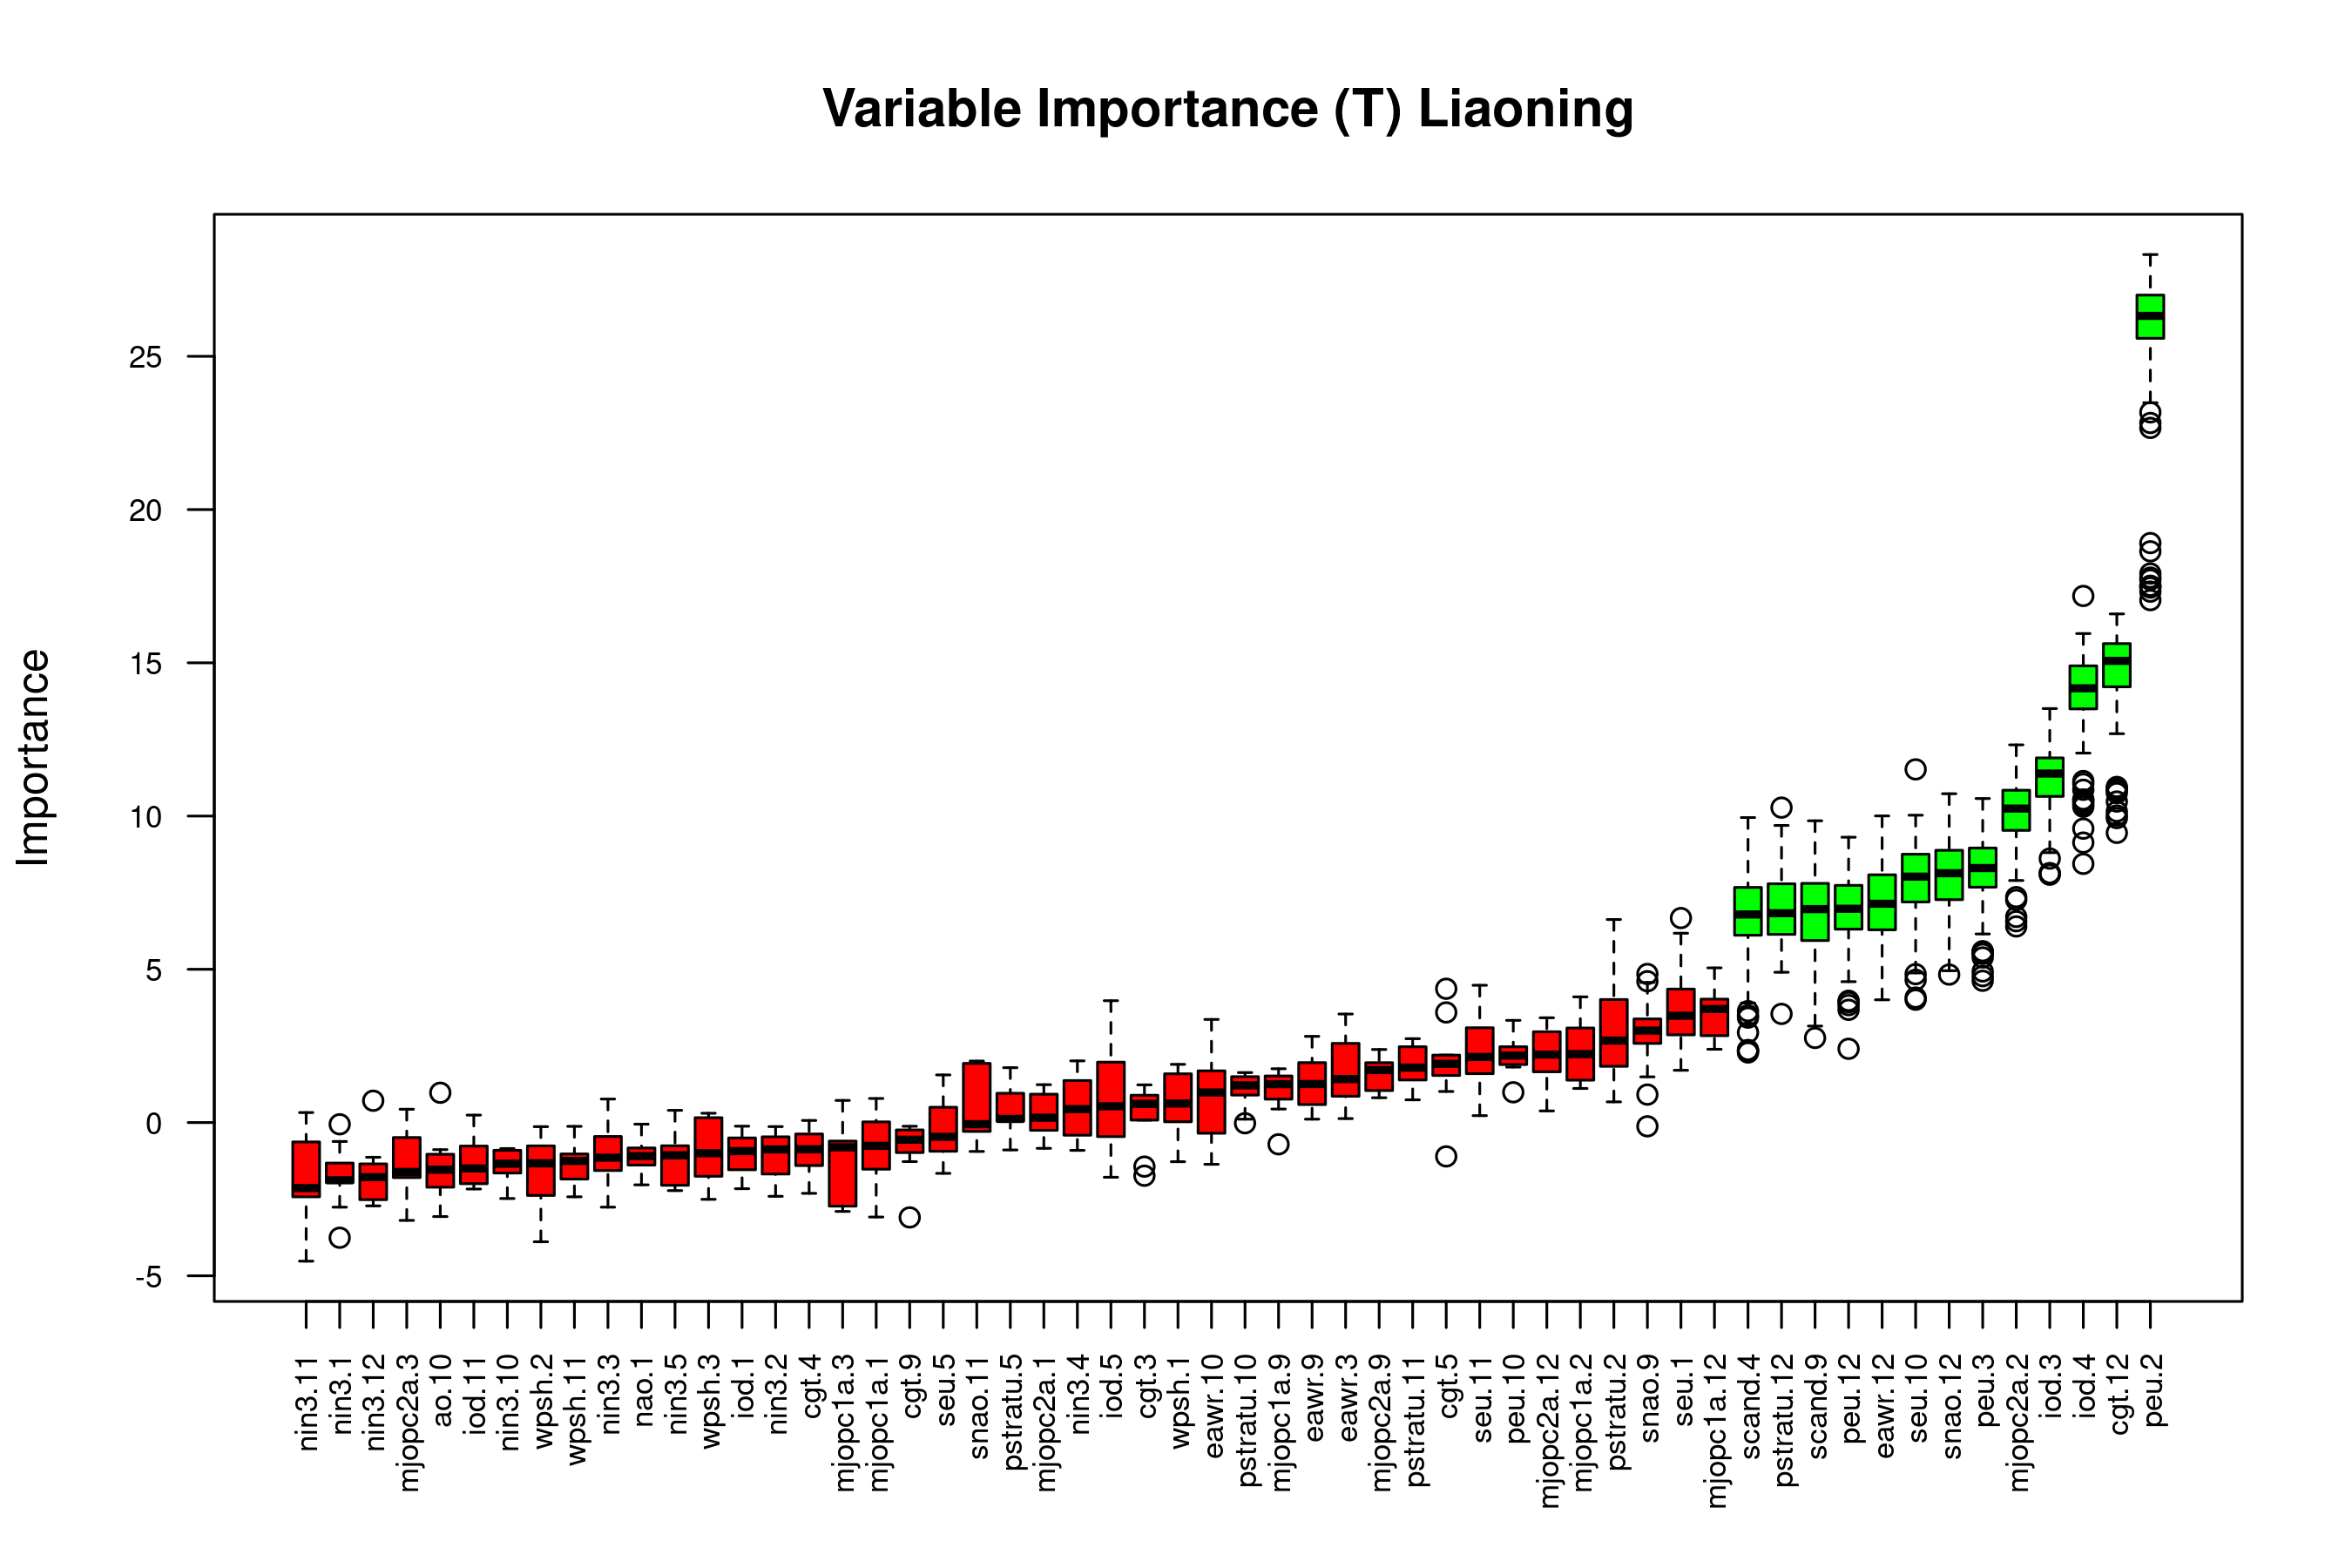

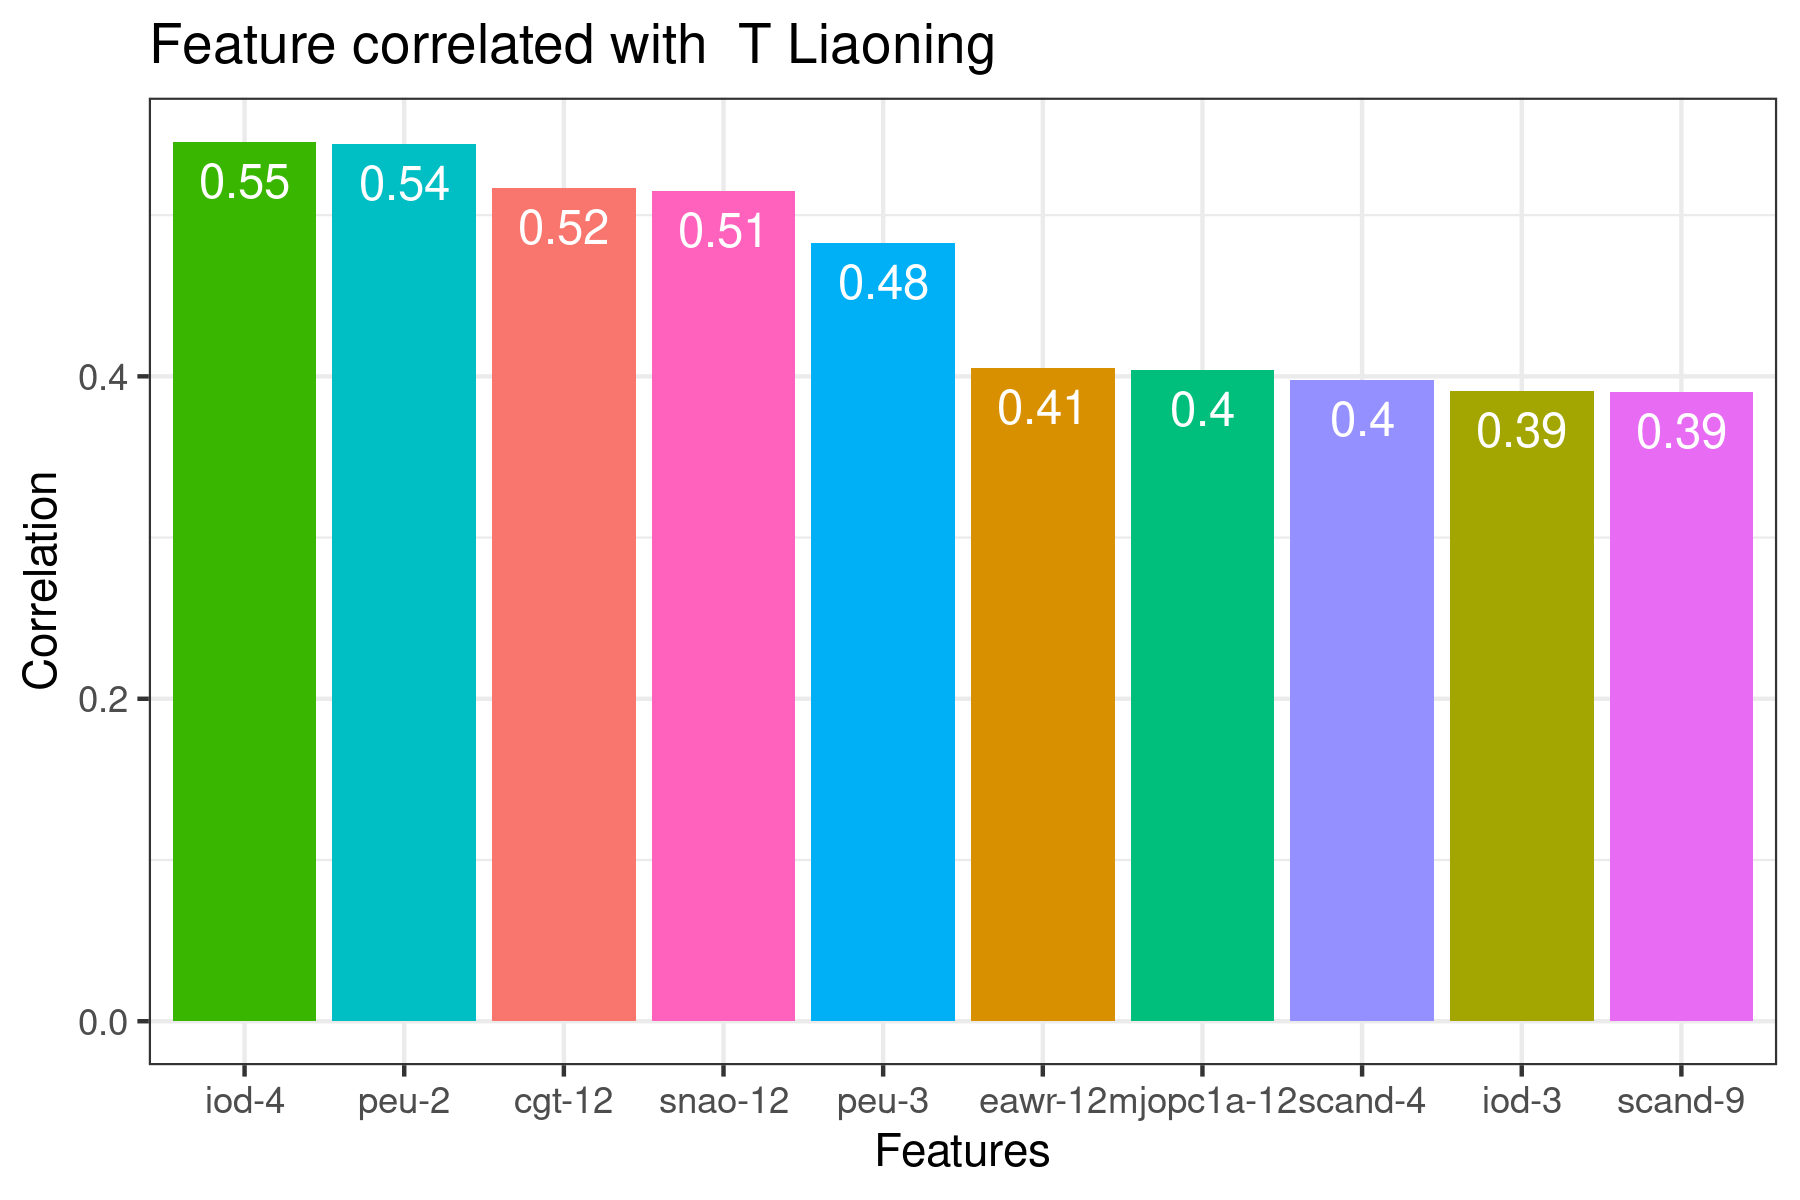

[1] "Jilin"
[1] 2


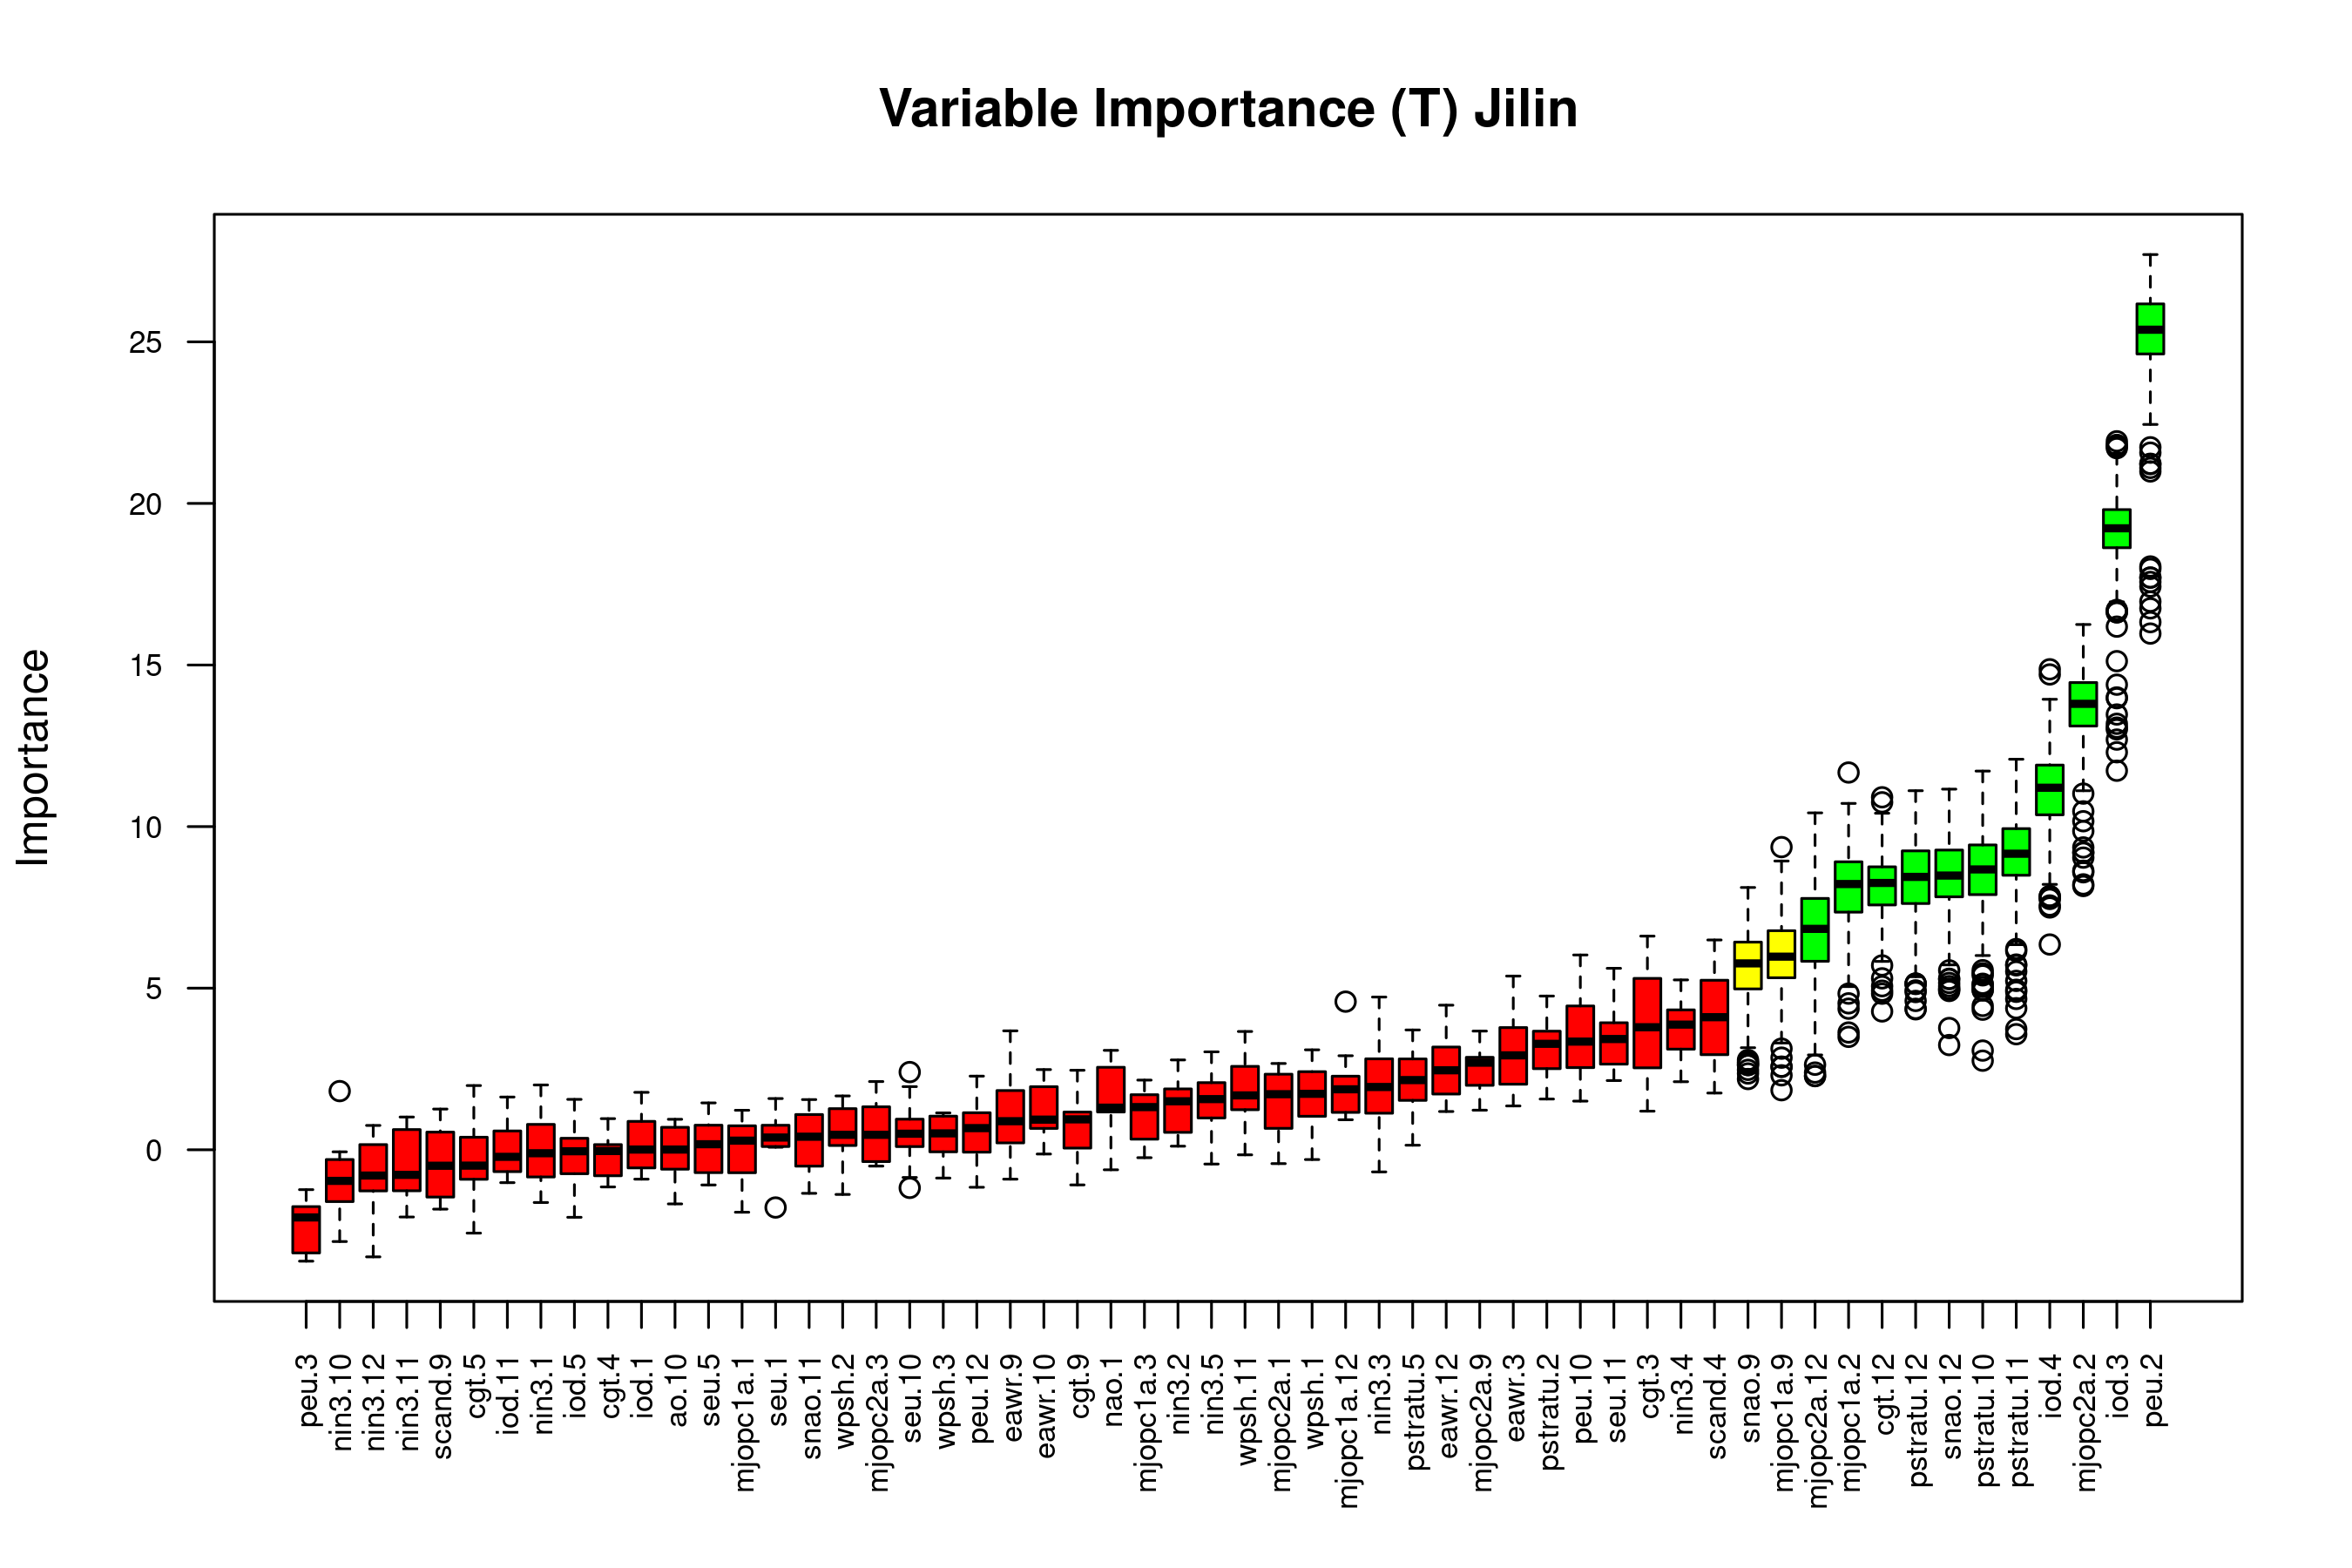

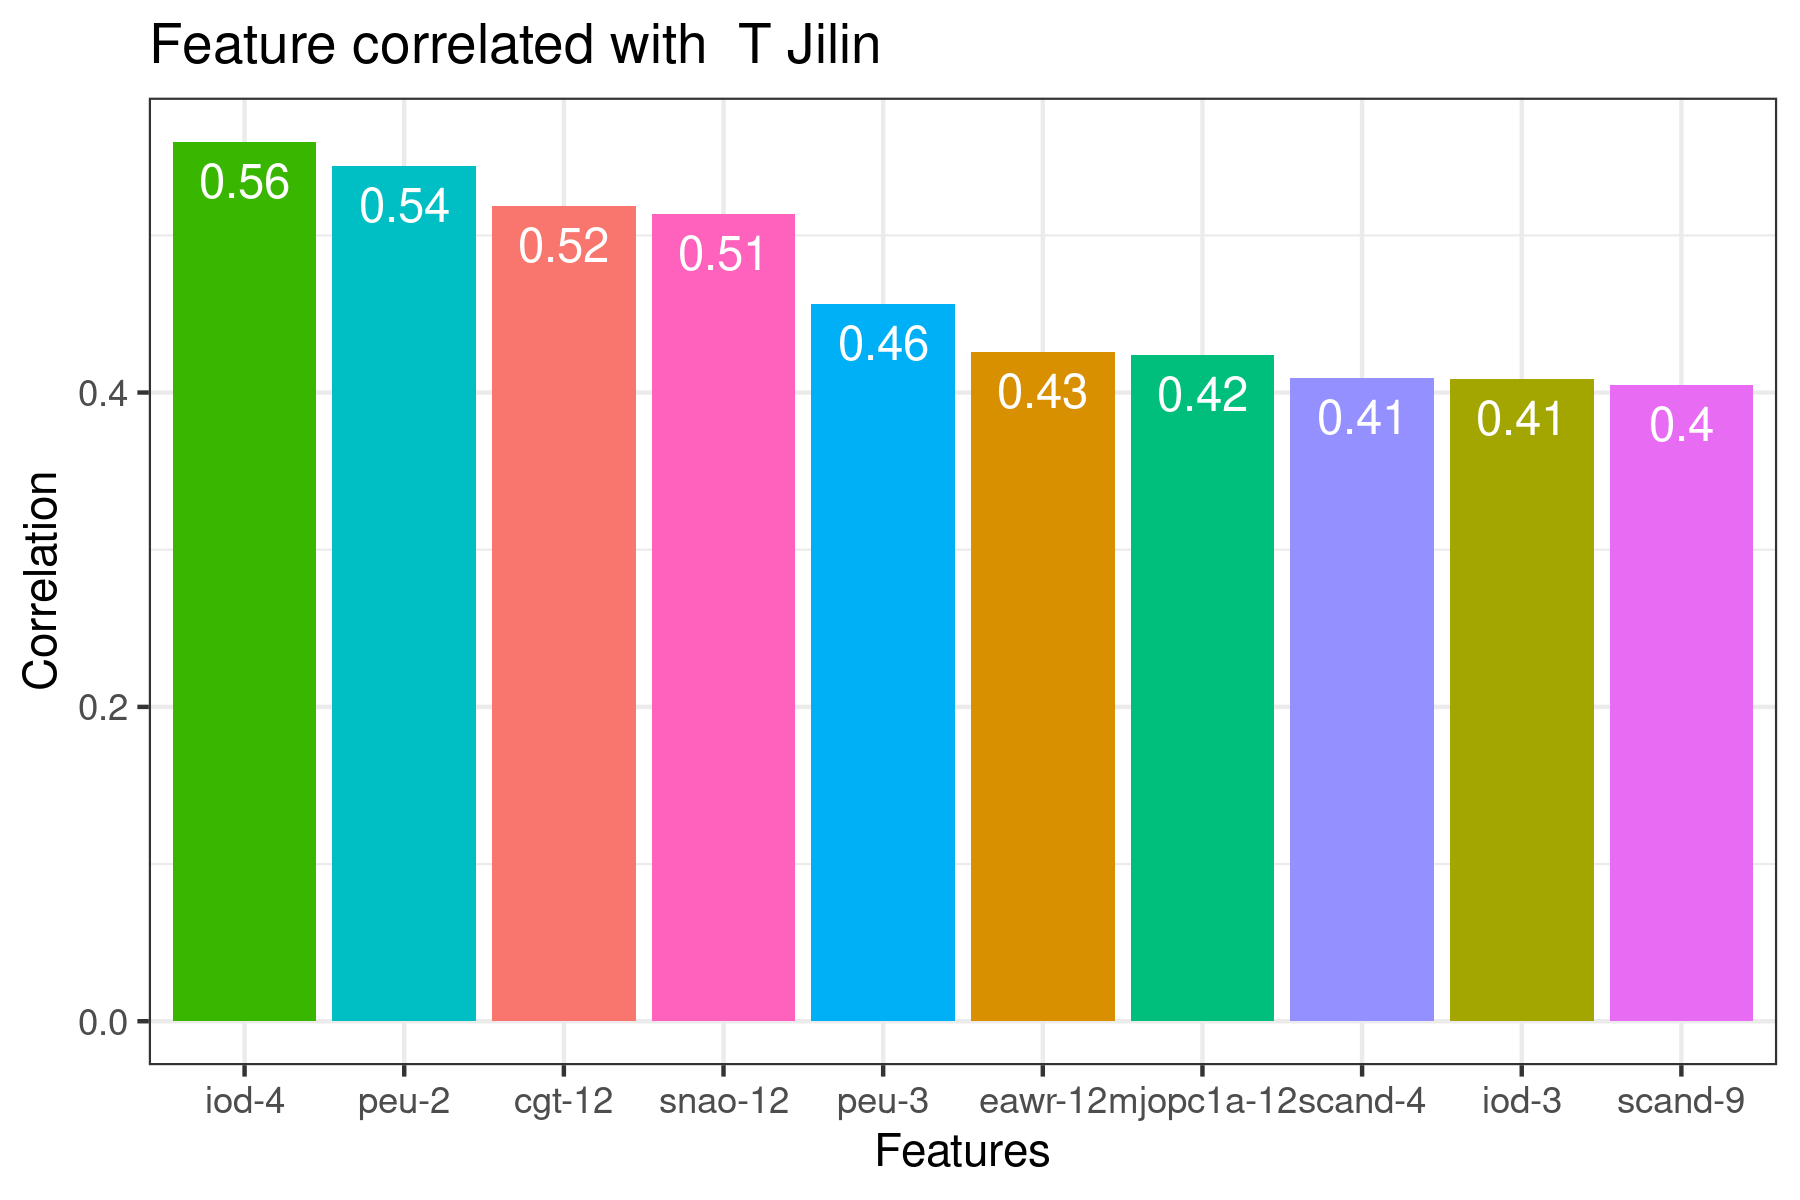

[1] "Heilongjiang"
[1] 3


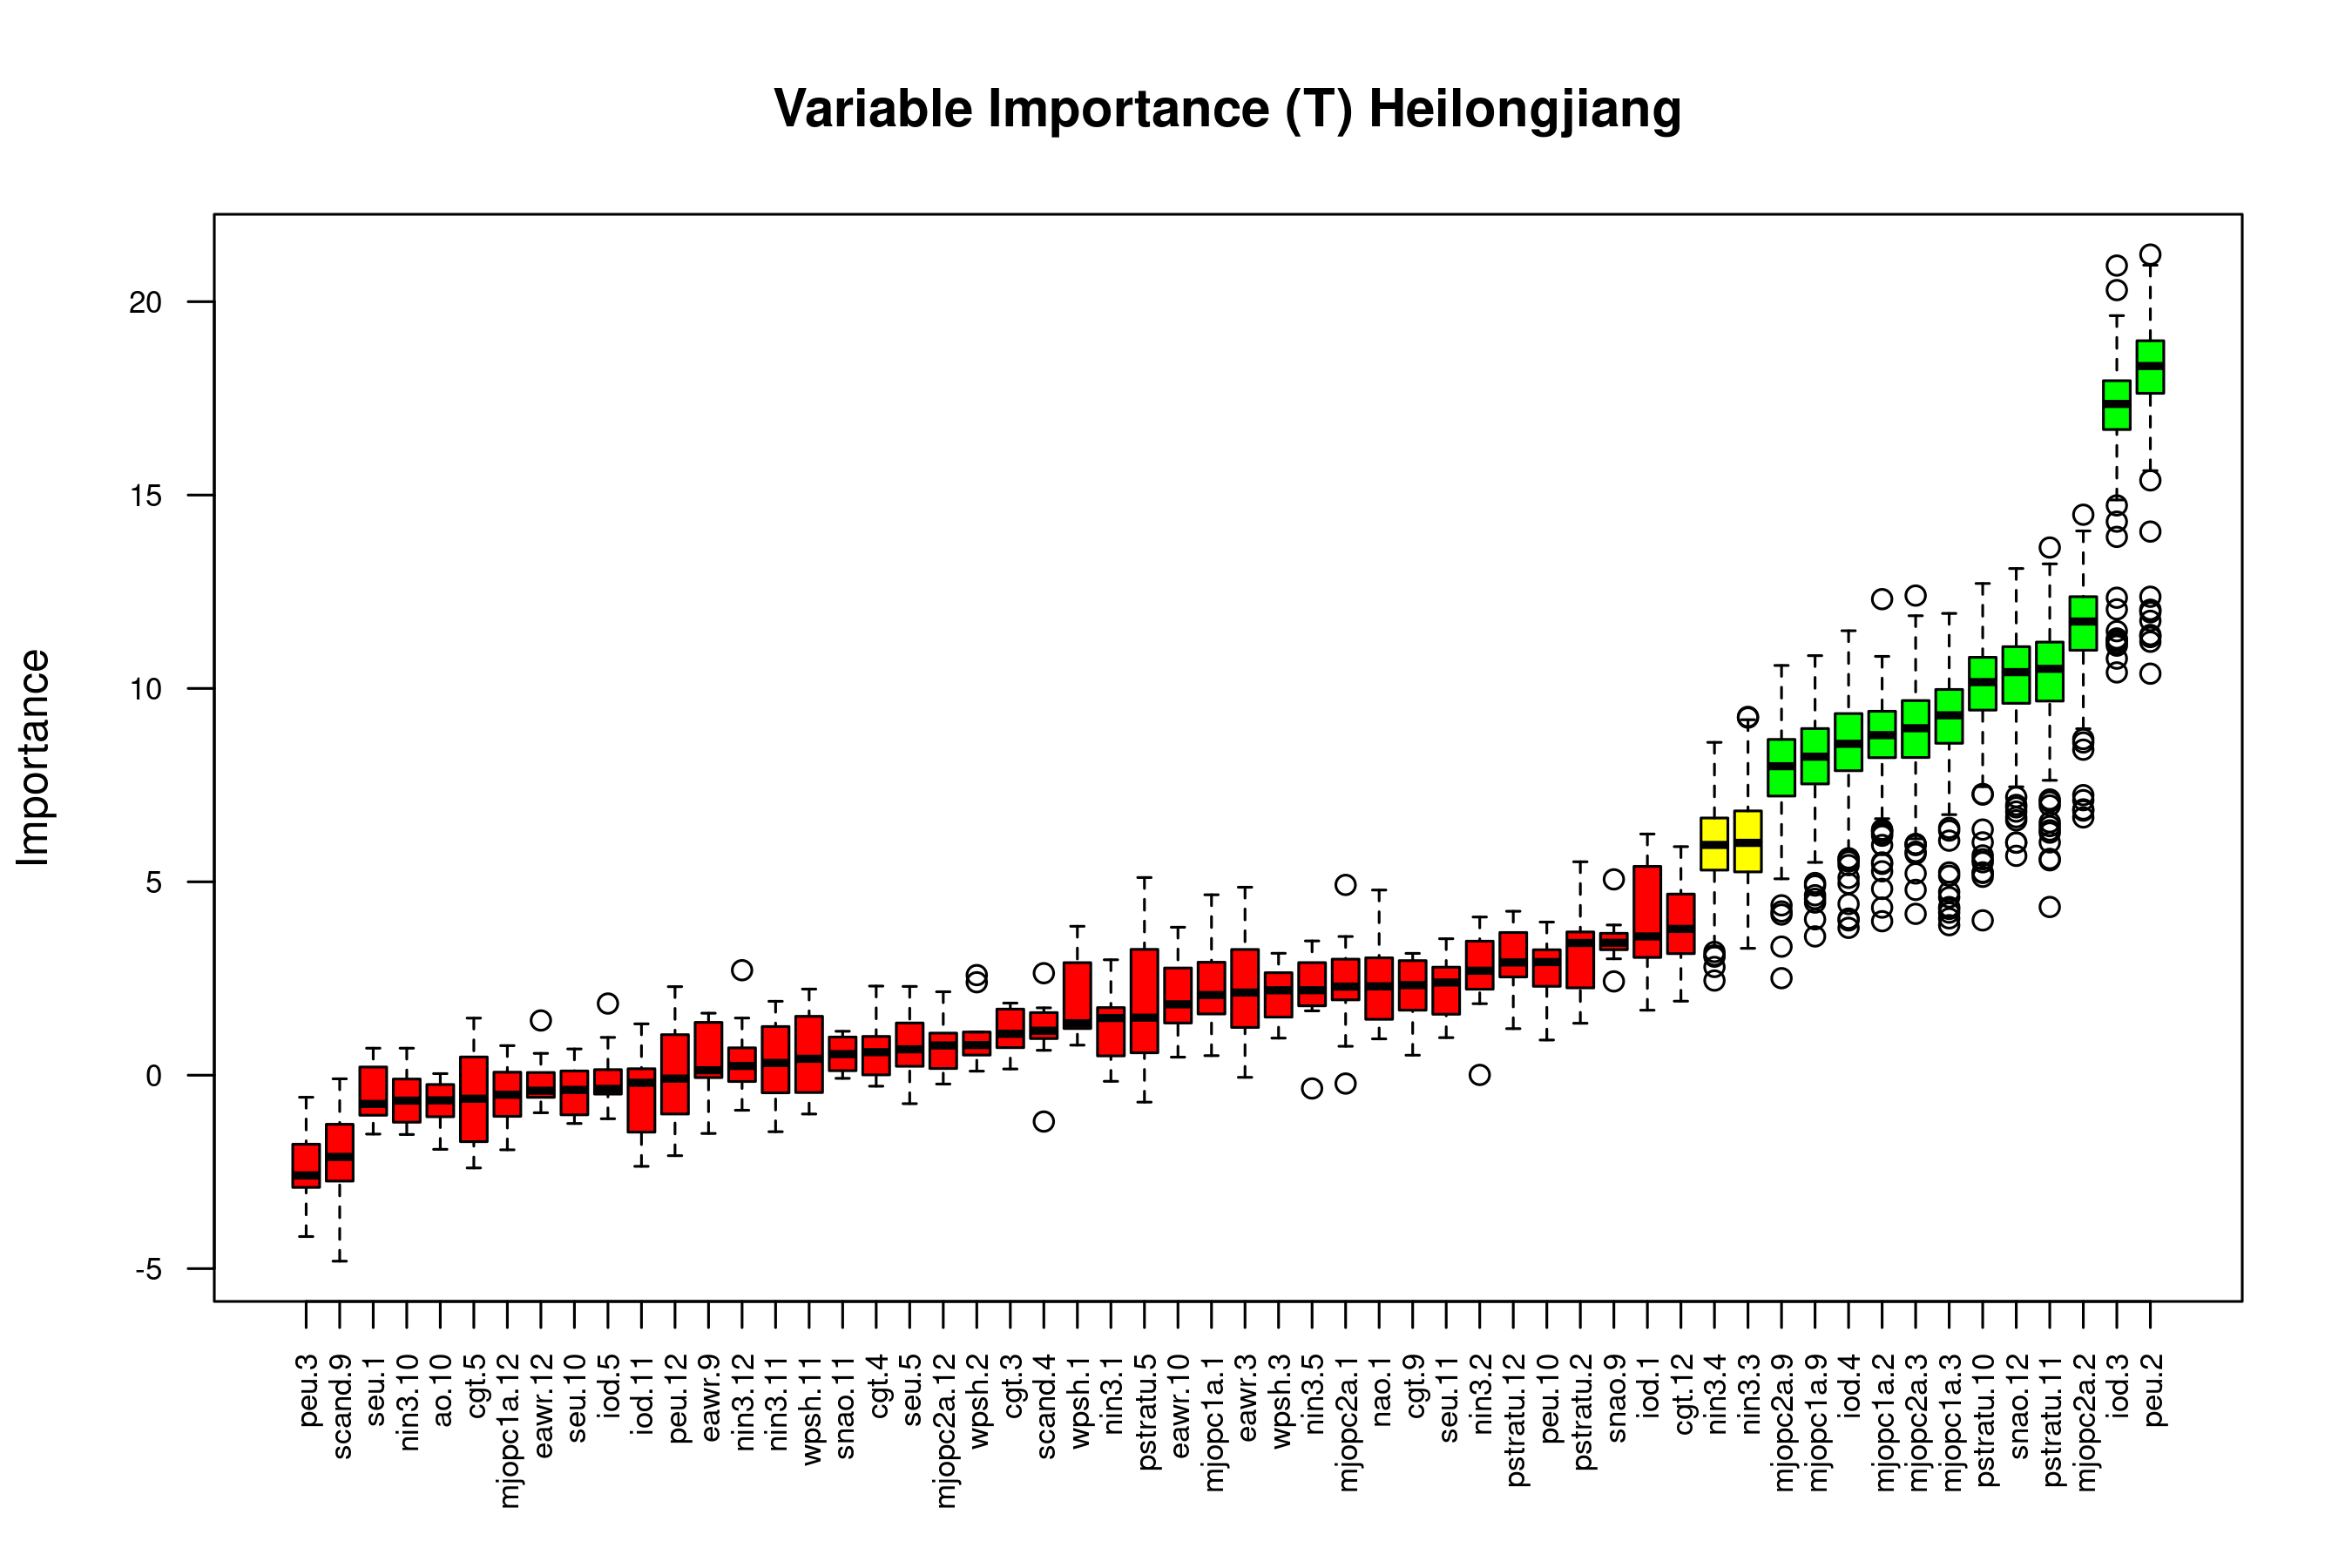

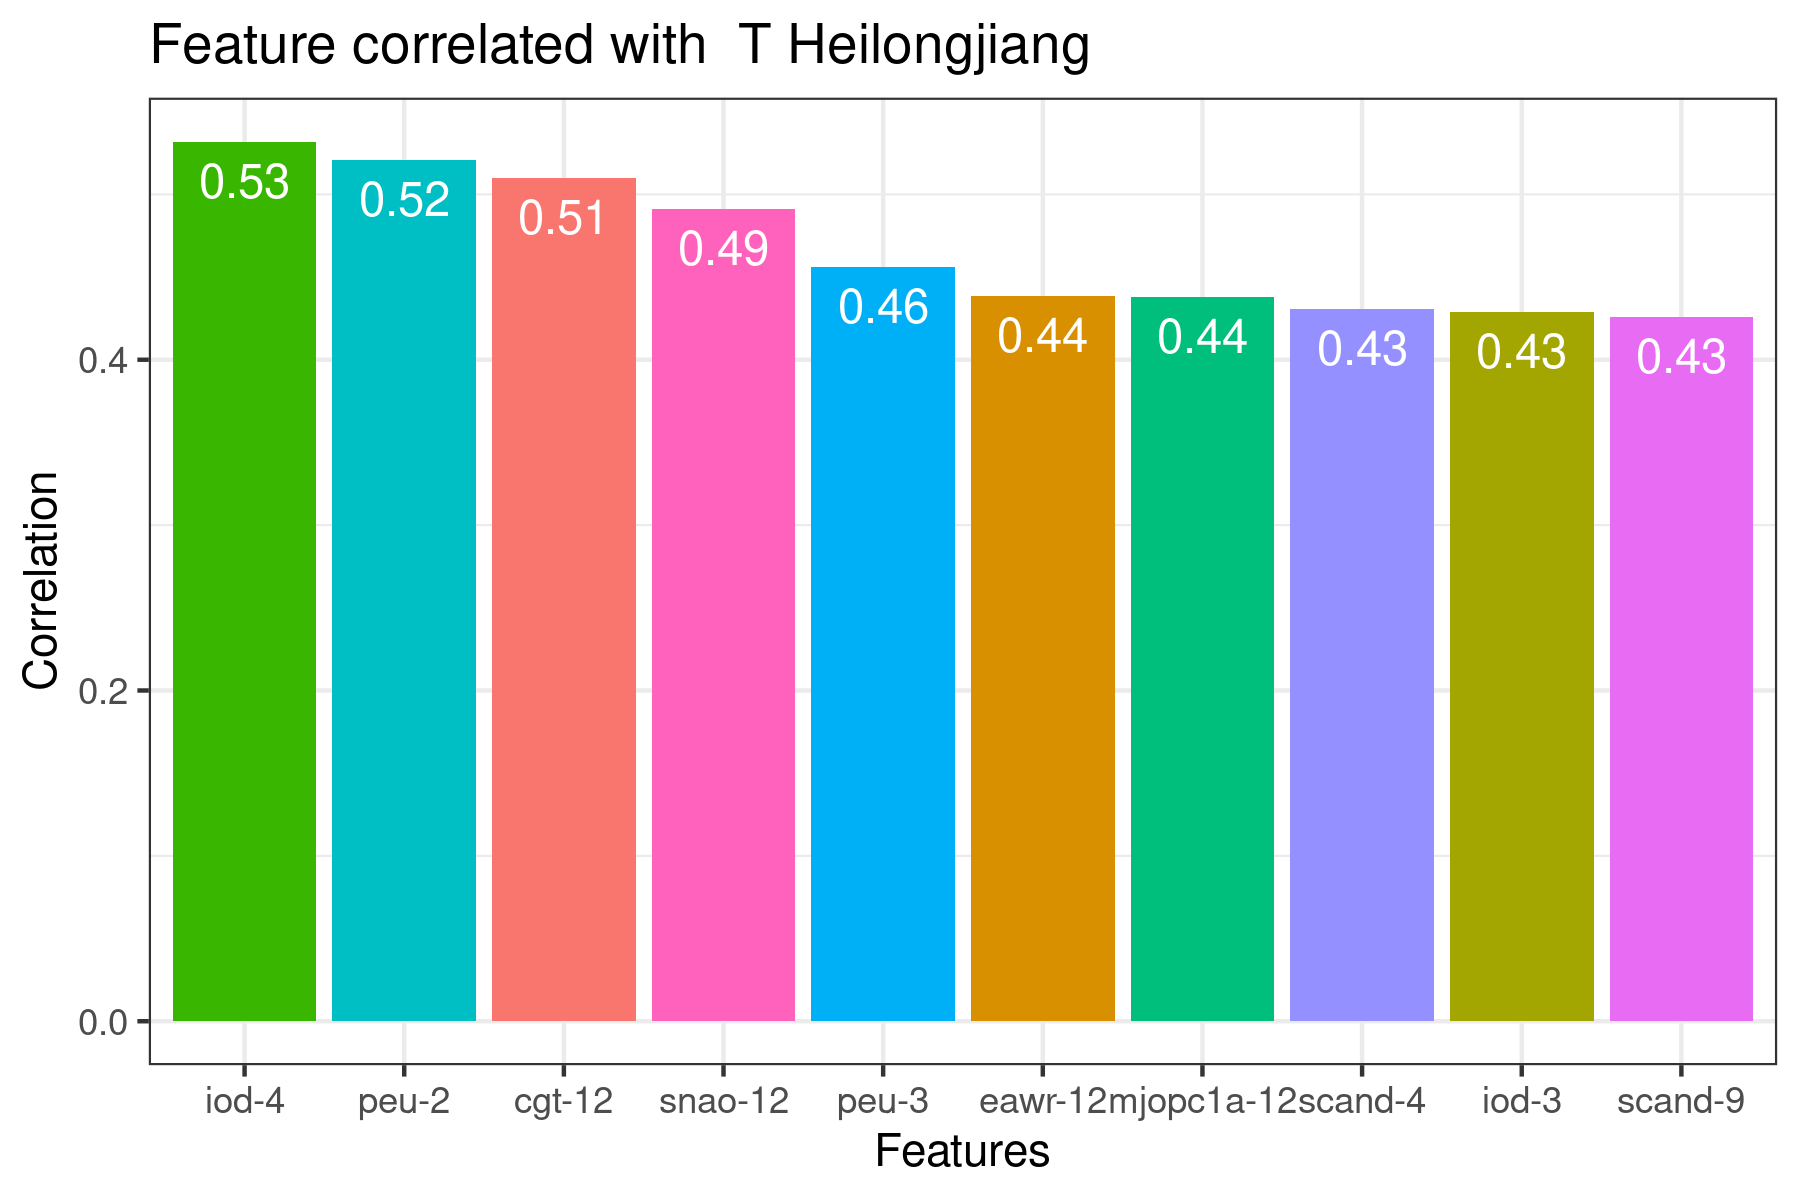

In [105]:
temp_x_train <- cindex_df[, important_temp_names]

sub = 2:(length(colnames(cindex_df)) + 1)

for (k in 1:length(regs)) {
    print(regs[k])
    print(k)
    temp_y_train <- temp_anoms[ ,k]
    
    set.seed(1)
    
    din_temp  = data.frame(cbind(temp_x_train, temp_y_train)) 

    pcrit = 0.05

    ts = array(NA, length(colnames(cindex_df)))
    
    ########################## Doing feature selection with random forest #######################################
    
    boruta_output_temp <- Boruta(temp_y_train ~ ., data=din_temp, doTrace=0, maxRuns= 400, ntree=4000, pValue = 0.1)
    boruta_signif_temp <- names(boruta_output_temp$finalDecision[boruta_output_temp$finalDecision %in% c("Confirmed", "Tentative")]) 
        
    png(paste('./',region,'_varimp_',regs[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep="")
        ,width=9,height=6,units="in",res=300)
    plot(boruta_output_temp, cex.axis=.7, las=2, xlab="", main=paste("Variable Importance (T)", regs[k]), whichShadow = c(FALSE, FALSE, FALSE))  # plot variable importance
    dev.off()
    display_png(file=paste('./',region,'_varimp_',regs[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep="")) 

    
    ######################### Storing our features ###################################################
    
    tvars = gsub("[[:punct:]]", "-", boruta_signif_temp) # list of selected temp features 
    
    coef_array_full[k,2,tvars] = 1
    
    
}

### Displaying the features information 

* Displaying which climate indices are predictors for each region 
    * Indices that tell us something about more than 1 region are most useful 
    
We produce the plots below using the variables found from the random forest. This tells us which variables are useful in which regions

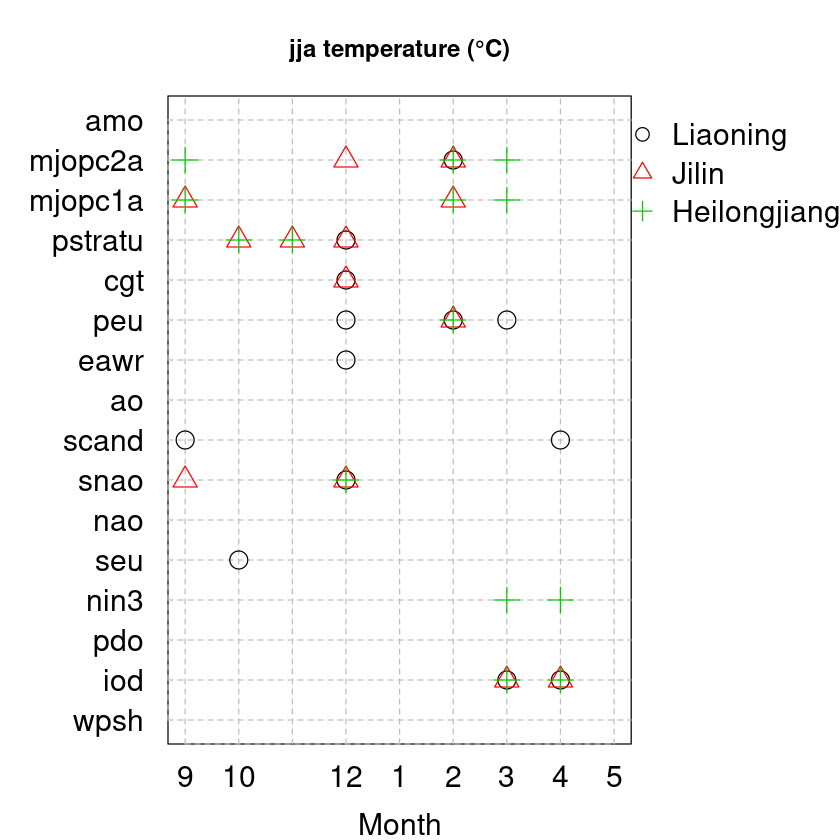

In [106]:
#png(paste('./', region,'_index_sig_mons_',num_vars,'_',ystrts,'_',yends,'_lag_',lag,'_',suffix,'.png', sep=""),width=10.25,height=12.25,units="in",res=300)
par(mfrow=c(1,1))
par(mar=c(4,7,4,8.7))
plot(NULL, xlim=c(1,length(mon_list)), ylim=c(1,length(ind_list)), ylab="", xlab="Month", 
     main = paste(suffix," temperature (\u00B0C)",sep=""), xaxt="n", yaxt="n", cex.lab=1.5)
#, xaxs="i", yaxs="i")
axis(1, at=1:length(mon_list), labels=mon_list,cex.axis=1.0, tck = 1, lty = 2, col = "grey", 
     cex.lab=1.5, cex.axis=1.5)
axis(2, at=1:length(ind_list), labels=ind_list,cex.axis=1.0, tck = 1, lty = 2, col = "grey", 
     cex.lab=1.5, cex.axis=1.5, las=1)

for (k in 1:1:length(regs)) {
    # for temperature 
    t_inds = which(abs(coef_array_full[k,2,sub]) > 0.5)
    tnames = strsplit(names(t_inds), split = "-")
    var_tind = numeric(0)
    mon_tind = numeric(0)
    
  
    ## match string to ind_list
    for (i in 1:length(t_inds)) {
    var_tind[i] = which(tnames[[i]][1] == ind_list)
    mon_tind[i] = which(as.numeric(tnames[[i]][2]) == mon_list)
    }
    points(mon_tind, var_tind, pch=k, col=k, cex=2)

}
legend("topright", legend = regs,bty = "n",
       pch = 1:length(regs), col=1:length(regs), 
       cex=1.5,xpd = TRUE, inset = c(-0.51, 0))

## Getting Jets

* Also do feature importance on the jets 

In [107]:
ndata = "/data/users/ncreaser/CSSP_china/data/Indices/"
j1u = "200hPa_zonal_polar_jet_new_monthly_longer.csv"
  #"200hPa_uwind_box1_monthly_longer.csv"
#j1u = "300hPa_uwind_polar_monthly_longer.csv"
#  "200hPa_uwind_box1_monthly_longer.csv"
j1v = "200hPa_vwind_box1_monthly_longer.csv"
#j1v = "300hPa_vwind_polar_monthly_longer.csv"
  #"200hPa_vwind_box1_monthly_longer.csv"
j2u = "200hPa_zonal_subtropical_jet_new_monthly_longer.csv"
  #"200hPa_uwind_box2_monthly_longer.csv"
#j2u ="300hPa_uwind_subtropical_monthly_longer.csv"
  #"200hPa_uwind_box2_monthly_longer.csv"
j2v = "200hPa_meridional_subtropical_jet_new_monthly_longer.csv"

# read yield, T and P data
j1udat = read.csv(paste(ndata,j1u, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)
j1vdat = read.csv(paste(ndata,j1v, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

j2udat = read.csv(paste(ndata,j2u, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)
j2vdat = read.csv(paste(ndata,j2v, sep=""), header = TRUE,sep = ",", stringsAsFactors = FALSE)

In [108]:
##### We havn't done anything with jets yet 
ystrt = 1981
yend = 2016
indyrsjet = which(j1udat[,1] == ystrt):which(j1udat[,1] == yend)

## calcaulte jja mean and de-trend
jmons = c("Mar", "Apr", "May", "Jun", "Jul", "Aug")
jmons_num = c(3,4,5,6,7,8)

j1ujja = j1udat[indyrsjet, jmons] 

colnames(j1ujja) = paste("eapju",jmons_num, sep="-")

j2ujja = j2udat[indyrsjet, jmons] 
colnames(j2ujja) = paste("easju",jmons_num, sep="-")

j1vjja = j1vdat[indyrsjet, jmons] 
colnames(j1vjja) = paste("eapjv",jmons_num, sep="-")

j2vjja = j2vdat[indyrsjet, jmons] 
colnames(j2vjja) = paste("easjv",jmons_num, sep="-")

jet_raw = as.matrix(cbind(j1ujja, j1vjja, j2ujja, j2vjja))

In [109]:
jet_df = array(NA, c(dim(jet_raw)[1], dim(jet_raw)[2]))
colnames(jet_df) = colnames(jet_raw)
rownames(jet_df) = rownames(cindex_df)

In [110]:
for (s in 1:dim(jet_raw)[2]) {
  # de-trend
  tt = 1:dim(jet_raw)[1]
  mod = lm(jet_raw[,s] ~ tt)
  jet_df[,s] = scale(mod$residual)
}

In [111]:
dx2 = 1+dim(jet_df)[2]

In [112]:
coef_jarray_full = array(0, c(length(regs),4,dx2))
dimnames(coef_jarray_full)[[3]] <- c("Intercept", colnames(jet_df))
dimnames(coef_jarray_full)[[1]] <- regs

[1] "Liaoning"
[1] "Selected temperature predictors"
[1] "eapju.6" "eapju.8" "eapjv.6" "easju.6" "easju.7" "easju.8"


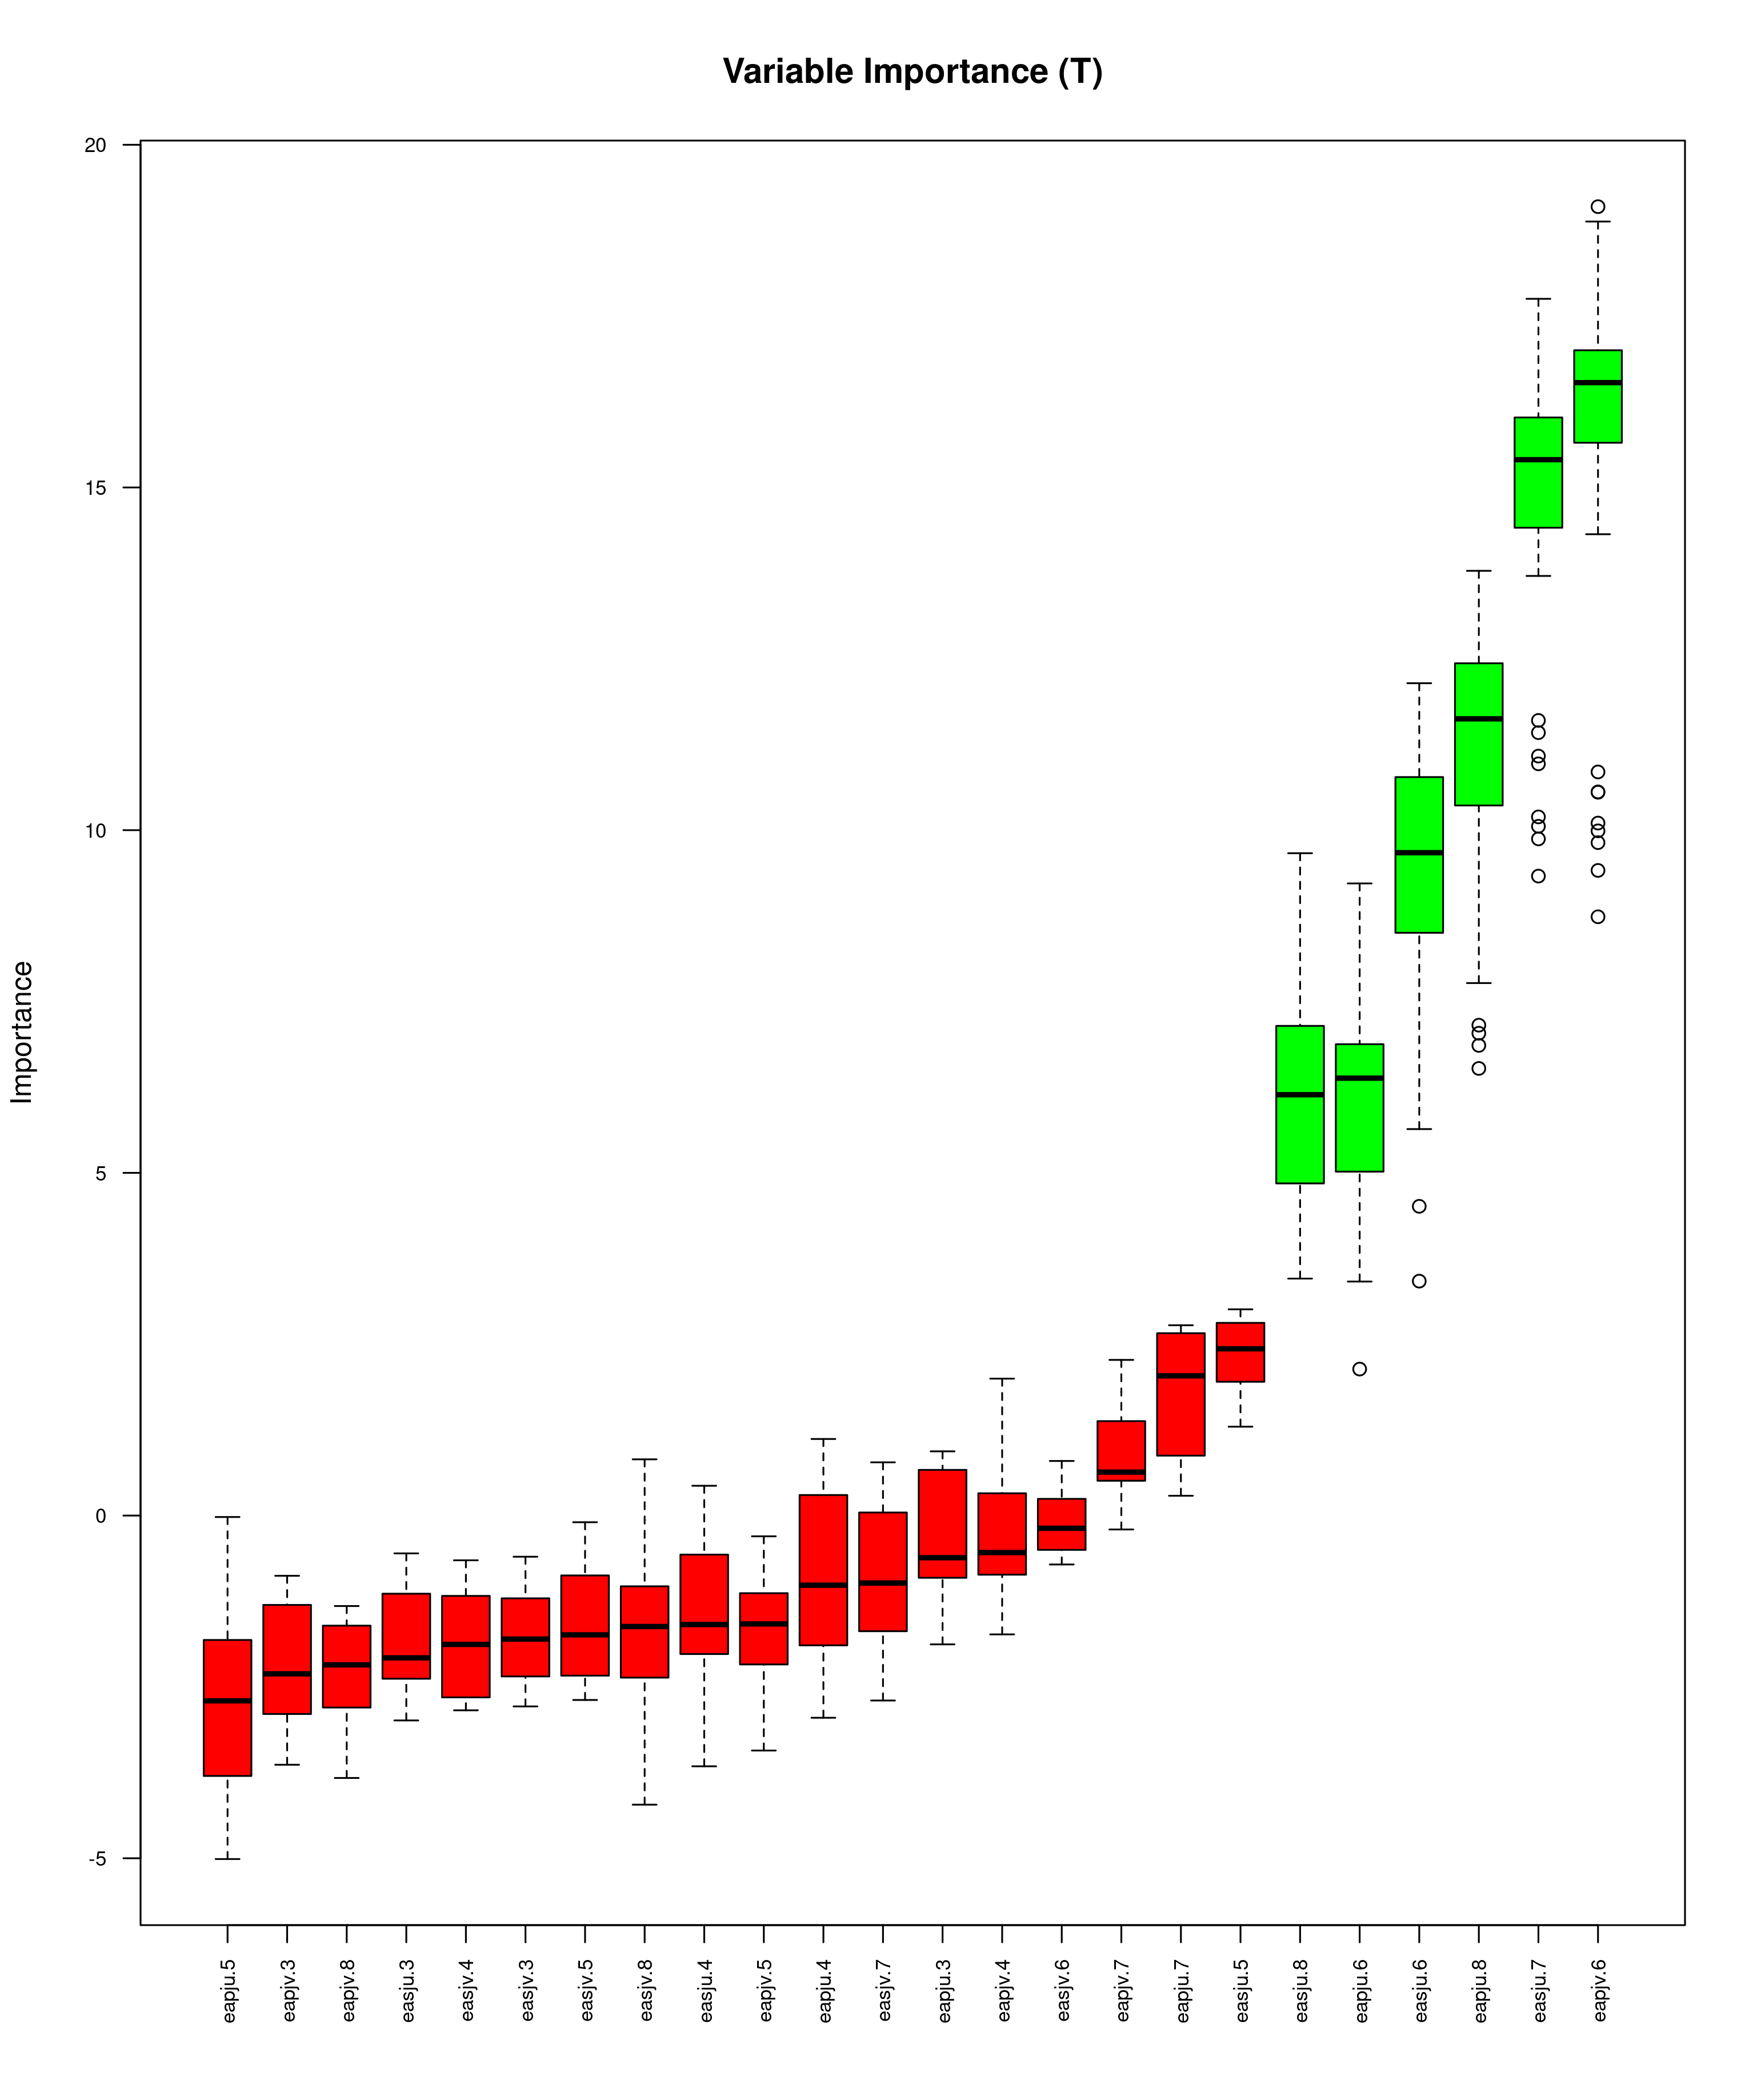

[1] "Jilin"
[1] "Selected temperature predictors"
[1] "eapju.6" "eapju.8" "eapjv.6" "easju.6" "easju.7" "easju.8" "easjv.4"


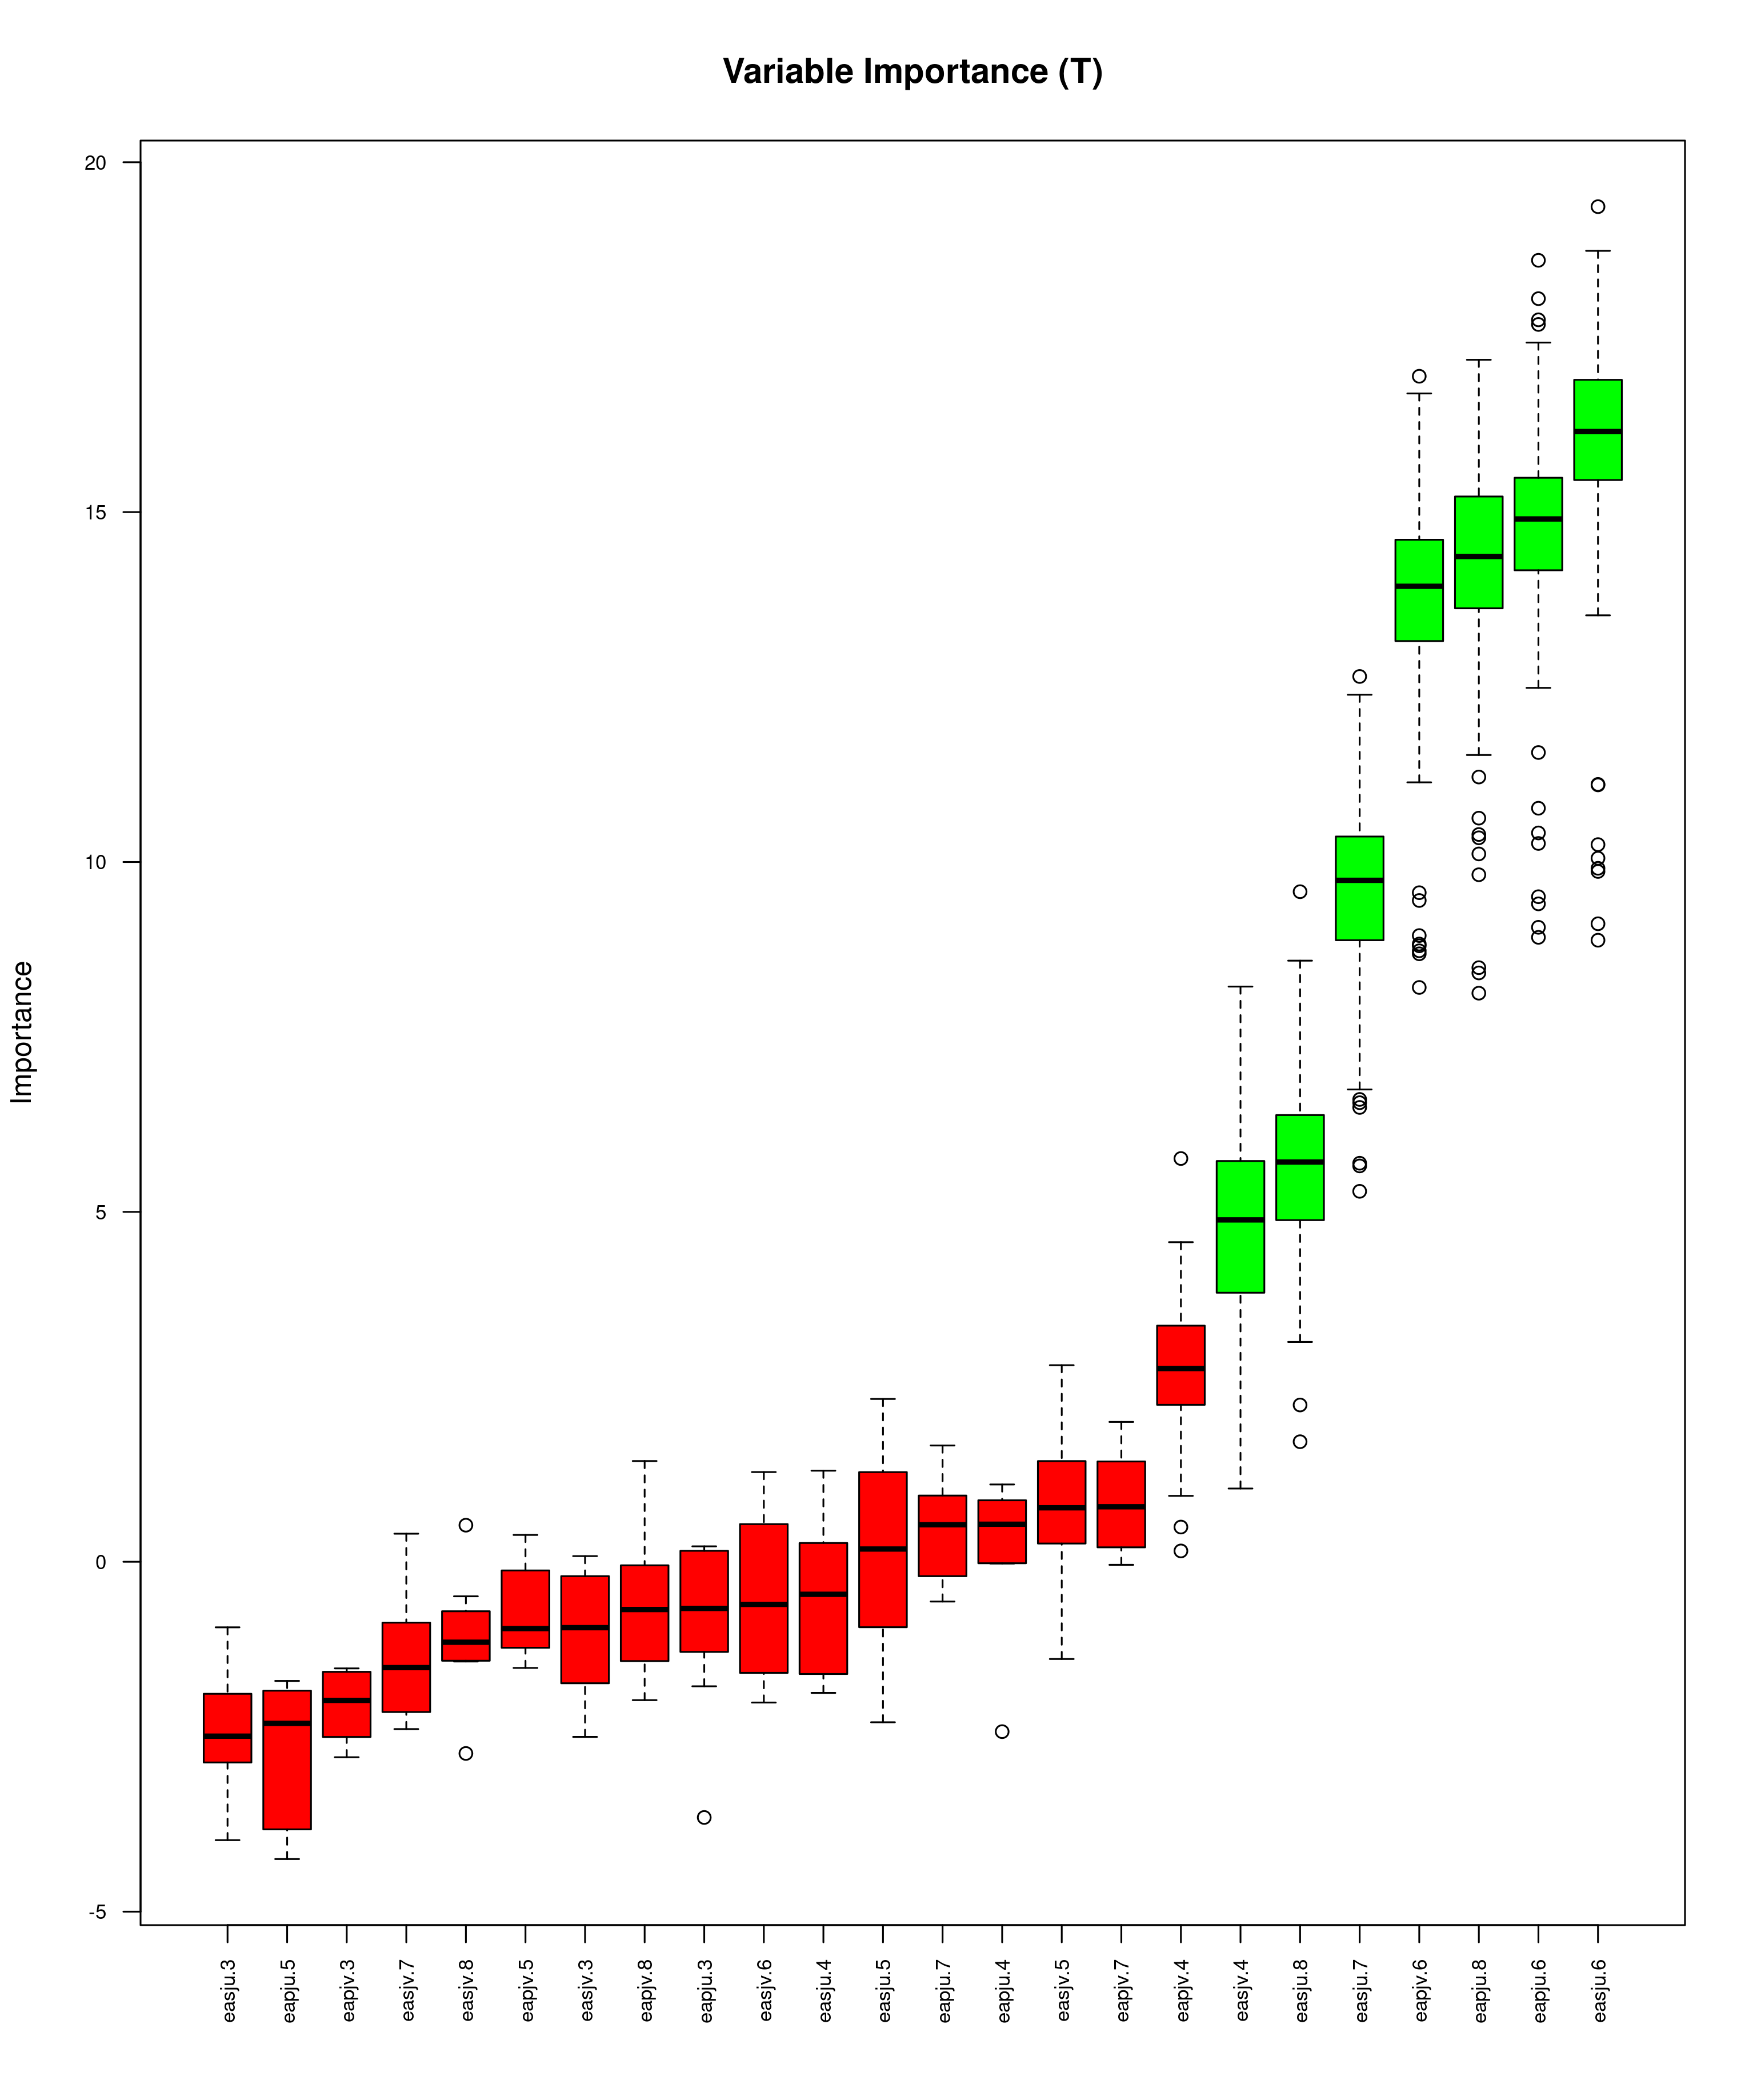

[1] "Heilongjiang"
[1] "Selected temperature predictors"
[1] "eapju.6" "eapju.8" "eapjv.4" "eapjv.6" "eapjv.7" "easju.6" "easju.7"
[8] "easju.8" "easjv.5"


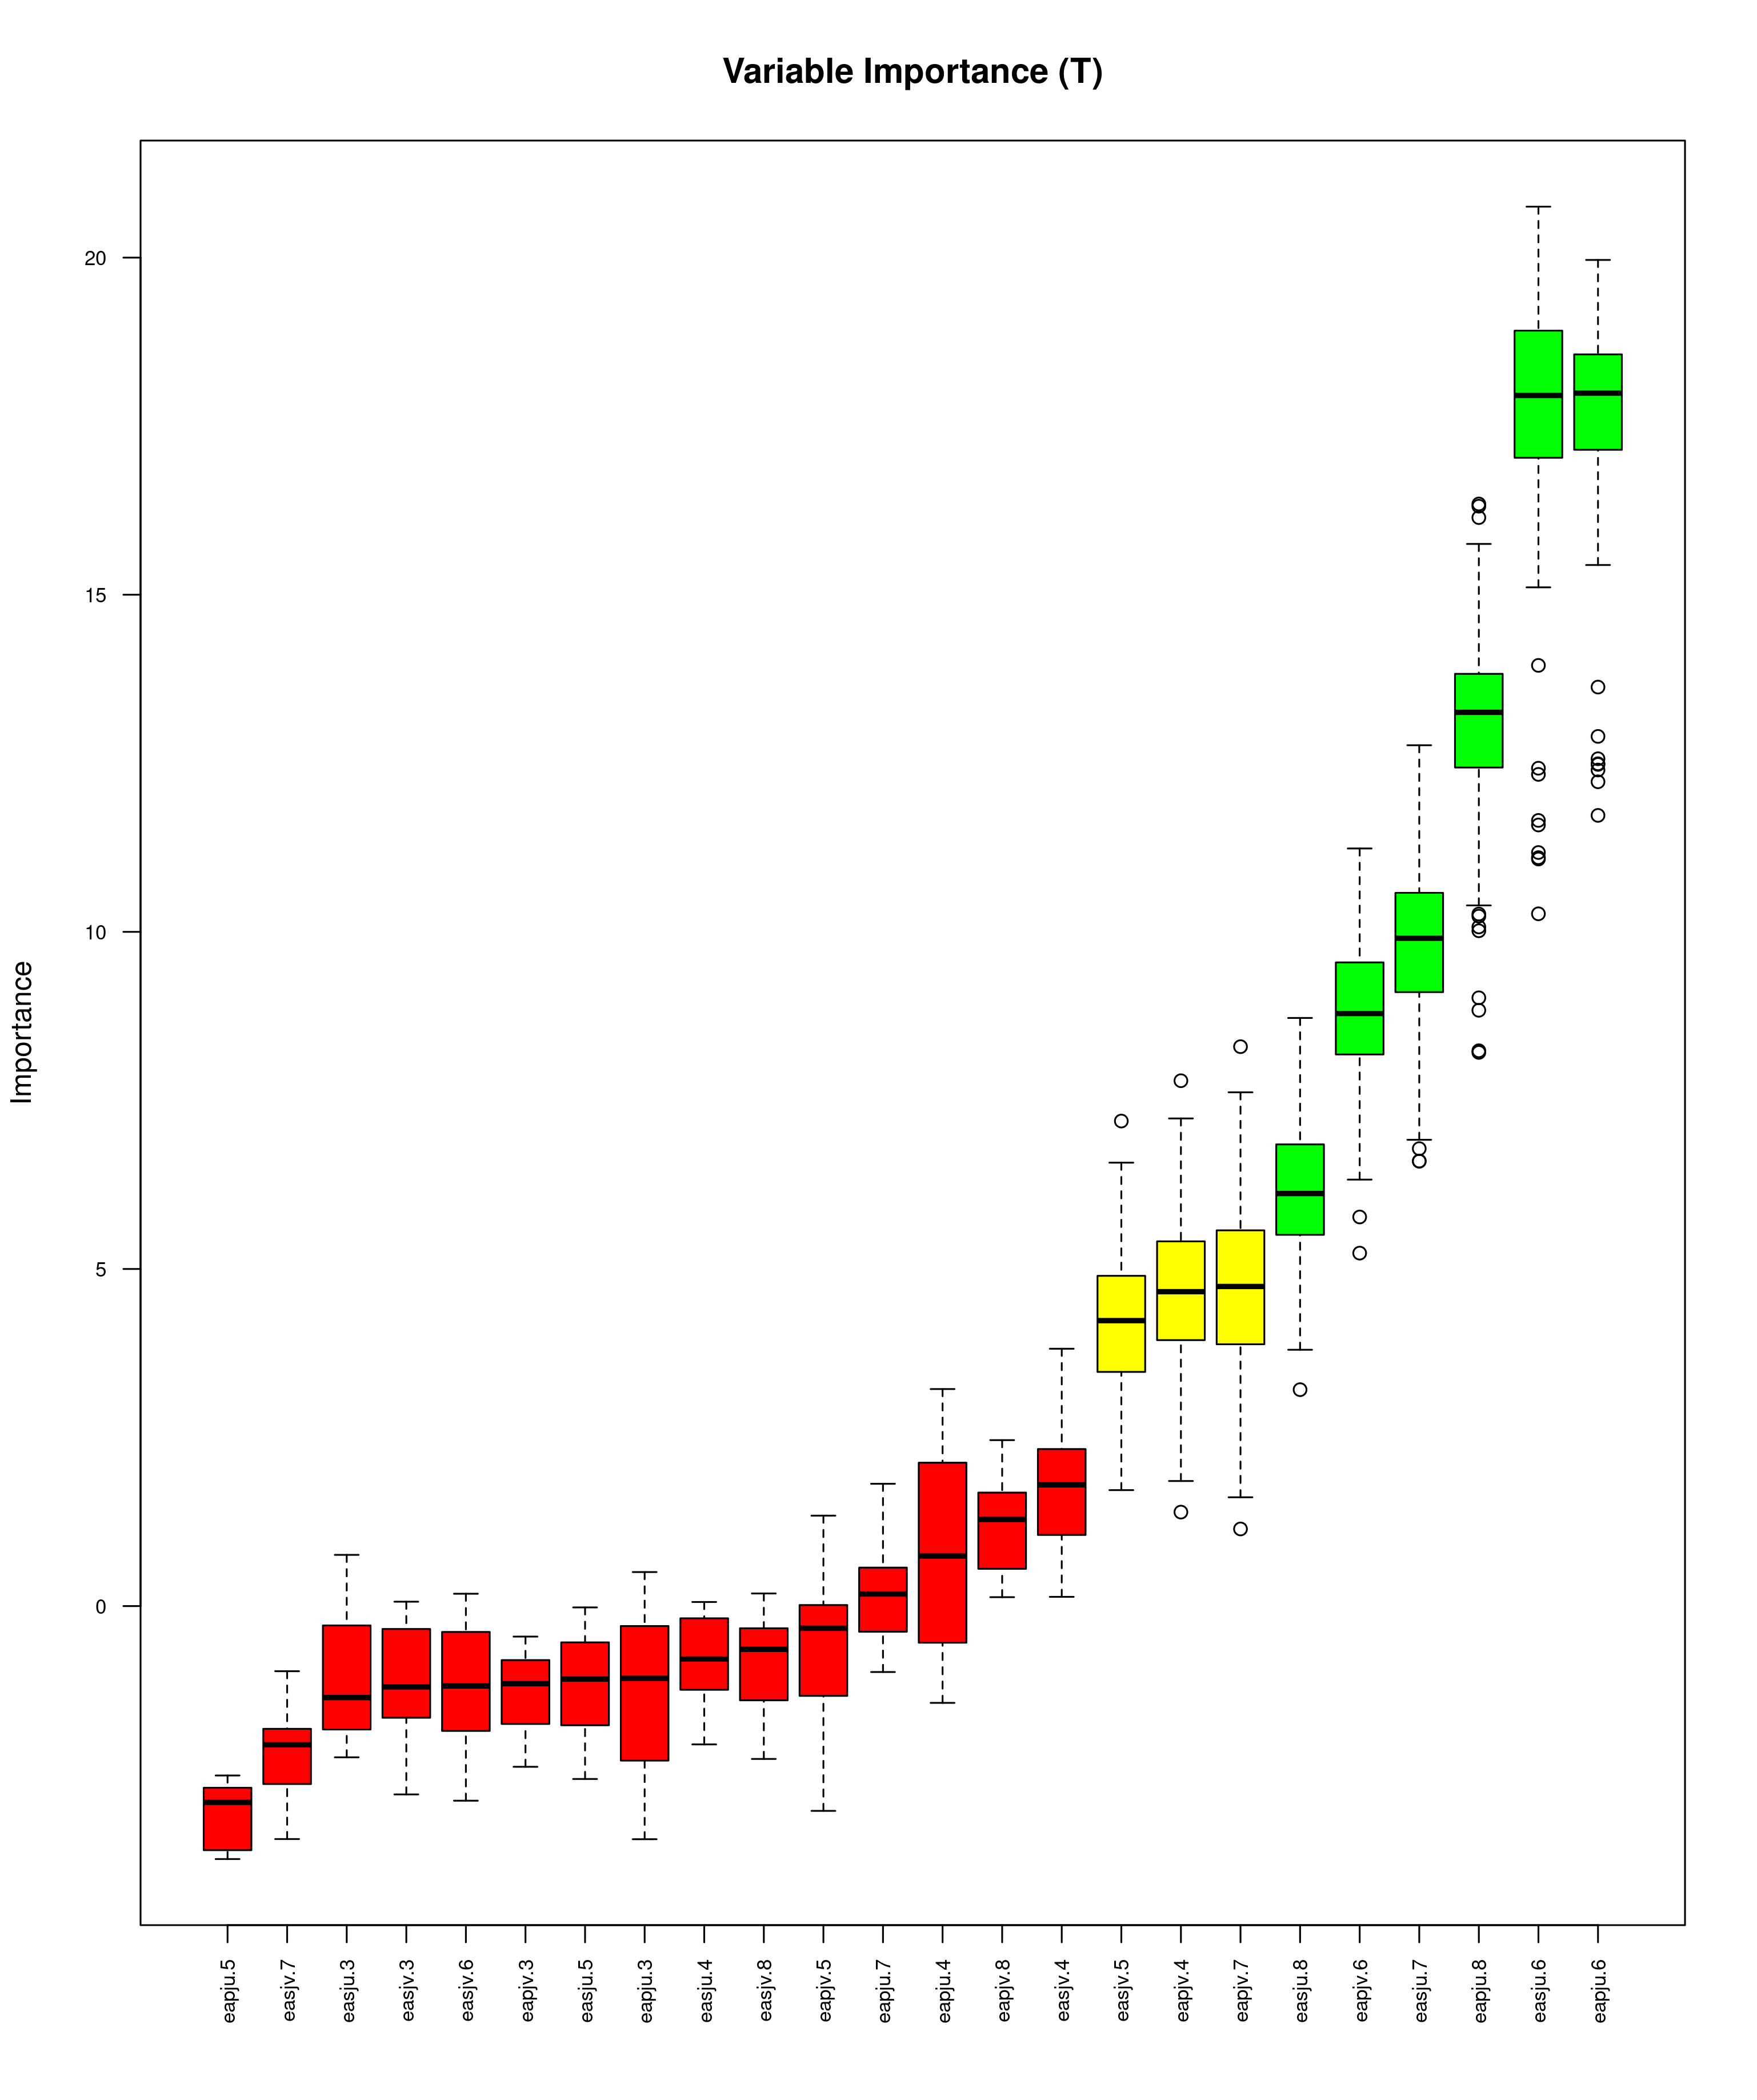

In [113]:
## do boruta on jet predicting t and P
for (k in 1:length(regs)) {
    print(regs[k])

    x_train = jet_df
    y_train = temp_anoms[,k]

    din1  = data.frame(cbind(x_train, y_train))
    boruta_output1 <- Boruta(y_train ~ ., data=din1, doTrace=0, maxRuns= 200, ntree=2000, pValue = 0.1)  # perform Boruta search

    boruta_signif1 <- names(boruta_output1$finalDecision[boruta_output1$finalDecision %in% c("Confirmed", "Tentative")])  # collect Confirmed and Tentative variables
    print("Selected temperature predictors")
    print(boruta_signif1) 

    ## remove shadows from plot
    png(paste('./china_maize_jet_varimp_',regs[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep=""),width=10.25,height=12.25,units="in",res=300)
    plot(boruta_output1, cex.axis=.7, las=2, xlab="", main="Variable Importance (T)", whichShadow = c(FALSE, FALSE, FALSE))  # plot variable importance
    dev.off()
    display_png(file=paste('./china_maize_jet_varimp_',regs[k],'_',ystrts,'_',yends,"_lag_",lag,'_',suffix,'.png', sep="")) 

    tvars = gsub("[[:punct:]]", "-", boruta_signif1)

    coef_jarray_full[k,2,tvars] = 1

}


# Create Bayesian Network  

In [114]:
library(bnlearn)
library(igraph)
library(compare)

In [115]:
get_blacklist2 <- function(mat, cindex_cols, eff_cols, monlist) {
  # mat is a data matrix containing causes and effects
  # eff_cols are the columns for the effects
  ##   
  # create a list of forbidden links, i.e. non-causal links
  # prevent regions from predicting each other and effects resulting in causes.
  cneffs = length(cindex_cols)  
  neffs = length(eff_cols)  
  # split the names
  tns = strsplit(colnames(mat), ".", fixed = TRUE)
  # put in a matrix
  tnsmat = matrix(unlist(tns),ncol=2,byrow=T)
  # order the months
  from_mons = numeric(0)   
  for (i in 1:(dim(mat)[2]-neffs)) {
    #     print(i)
    from_mons[i] = which(as.numeric(tnsmat[i,2]) == monlist)
  }
  
  # find which links would be backwards in time
  from_to = numeric(0)
  for (i in 1:length(from_mons)) {
    to_mons = which(from_mons < from_mons[i])
    from_names = rep(colnames(mat)[i], times=length(to_mons))
    to_names = colnames(mat)[to_mons]
    from_to_new = cbind(from_names, to_names)
    # now add to "from_to"  
    from_to = rbind(from_to, from_to_new)
  }
  # make sure each effect can't cause anything, repeat over all effect columns
  #from_names = rep(colnames(mat)[dim(mat)[2]], times=(dim(mat)[2]-neffs))
  #to_names = colnames(mat)[1:(dim(mat)[2]-neffs)]
  for (k in 1:neffs) {
    # get the name of the effect, and repeat by the number of columns - 1 (i.e. from itself to every other column)
    from_names = rep(colnames(mat)[eff_cols[k]], times=(dim(mat)[2]-1))
    # link to all other columns (just drop the current col name)
    to_names = colnames(mat)[-eff_cols[k]]
    from_to_new = cbind(from_names, to_names)
    ## Add to "from to"
    from_to = rbind(from_to, from_to_new)
  }
  
  if (cneffs != 0) {
    for (k in 1:neffs) {
    # get the name of the climate index effect, and repeat by the number of effects)
      from_names = colnames(mat)[cindex_cols]
    # link to all effects
      to_names = rep(colnames(mat)[eff_cols[k]], times=length(from_names))
      from_to_new_new = cbind(from_names, to_names)
    ## Add to "from to"
      from_to = rbind(from_to, from_to_new_new)
    }
  }  
  # return th list
  return(from_to) 
}

In [116]:
## Create networks, store networks, parents and predictor performance
t_parent = vector("list", length = length(regs))
t_parent_all = vector("list", length = length(regs))

tbn_all = vector("list", length = length(regs))
t_loss = array(NA, c(length(regs)))

dx = 1+dim(cindex_df)[2]
dx2 = 1+dim(jet_df)[2]
# need a column for the intercepts
  #(length(ind_list)*length(yrs_array[1,]))
sub= 2:dx
sub2 = 2:dx2


t_inds_all_all = unique(which(abs(coef_array_full[,2,sub]) > 0.5, arr.ind=TRUE)[,2])
tj_inds_all_all = unique(which(abs(coef_jarray_full[,2,sub2]) > 0.5, arr.ind=TRUE)[,2])
inds_all = unique(c(t_inds_all_all))
jinds_all = unique(c(tj_inds_all_all))

# generate the network including jets 
tmat3 = data.frame(cindex_df[,t_inds_all_all], jet_df[,tj_inds_all_all], temp_anoms)
                   #jet_df, temp_anoms)
                   #j
all_mon_list = unique(c(mon_list, jmons_num))
# indices of the effects
eff_cols = (dim(tmat3)[2]-length(regs) + 1):dim(tmat3)[2]
cindex_cols = 1:(dim(cindex_df[, t_inds_all_all])[2])
tbl3 = get_blacklist2(tmat3, cindex_cols, eff_cols, all_mon_list)
ga = hc(tmat3, blacklist = tbl3)
g2 = boot.strength(tmat3, R = 1000, algorithm = "hc", algorithm.args = list(blacklist = tbl3, score="bic-g"))
#g2_thrsh = g2[,3]
thrsh = seq(0.0,1.0, length.out=100)
  #sort(g2_thrsh, decreasing=T)
t_all_linked = character(0)
## loop through threshold to find minimum threshold for which each variable has at least one link to it.
for (h in 1:length(thrsh)) {
  t_all_linked[h] = compare::compare(unique(g2[,2]), unique(g2[which(g2[,3] >= thrsh[h]),2]), allowAll = TRUE, shorten = FALSE)$result
#  print(unique(g2[which(g2[,3] >= g2sorted_thrsh[h]),2]))
}
## find minimum threshold for which all nodes have at least one link to them.
tmin_ind = max(which(t_all_linked == TRUE))

gta = averaged.network(g2)
#, threshold=thrsh[tmin_ind])
#browser()
gbna = bn.fit(gta, tmat3)
## get parents of parents, i.e. what are the cliamte indices that predict the jets that predict temperature. 
for (k in 1:length(regs)) {
  ## get parents
  tps = parents(gbna, colnames(tmat3)[eff_cols[k]])
  tns = character(0)
  ## loop through parents to find their parents
  for (n in 1:length(tps)) {
    tpars = parents(gbna, tps[n])
    cinds = gsub("[[:punct:]]", ".", colnames(cindex_df)[t_inds_all_all])
    tpars_match = match(cinds, tpars)
    tns = c(tns, cinds[which(!is.na(tpars_match))])
  }
  t_parent_all[[k]] = unique(tns)
}


#gbna = bn.fit(ga, tmat3)
gga = as.igraph(gta)
gg2a = simplify(gga)
isolateda = which(degree(gg2a)==0)
gg3a = delete.vertices(gg2a, isolateda)
la = layout_with_gem(gg3a)
## get p-value of each link
gbnas = arc.strength(gta, tmat3)
E(gg3a)$color <- "gray"
E(gg3a)[adj("Liaoning.T")]$color = "black"
E(gg3a)[adj("Jilin.T")]$color = "black"
E(gg3a)[adj("Heilongjiang.T")]$color = "black"
# Get names
tnetworknames = gsub("[[:punct:]]", "-", names(degree(gg3a)))
#  pallnames = gsub("[[:punct:]]", "-", colnames(pmat2))
tclim_inds = match(colnames(cindex_df)[t_inds_all_all], tnetworknames)
tjet_inds =  match(colnames(jet_df)[tj_inds_all_all], tnetworknames)
  #match(colnames(jet_df), tnetworknames)
colst = c(rep("Orange", times = length(tclim_inds[is.finite(tclim_inds)])), rep("Yellow", times = length(tjet_inds[is.finite(tjet_inds)])), rep("white", times=length(regs)))
#  colst = c(rep("Orange", times = (length(t_inds_all)+length(tj_inds_all)-length(isolateda))), rep("white", times=1))
shapesl = c("circle", "square", "csquare", "rectangle", "crectangle", "vrectangle")
varname = "all temperature"
vname = "all_temperature"
png(paste('./china_maize_network_',vname,'_jet_',ystrts,'_',yends,"_lag_",lag,"_",suffix,'.png', sep=""), width=10.25,height=12.25,units="in",res=400)
#dev.new(width=10.25, height=12.25)
plot(gg3a, layout=la, edge.width = sqrt(-log(gbnas[,3])), vertex.size = 7.0+0.5*degree(gg3a), vertex.color = colst, cex=4, main=varname, resolution=2)
#vertex.color=rainbow(3, alpha=0.6)[clusterlouvain$membership], main=varname, resolution=2)
dev.off()


png 
  2

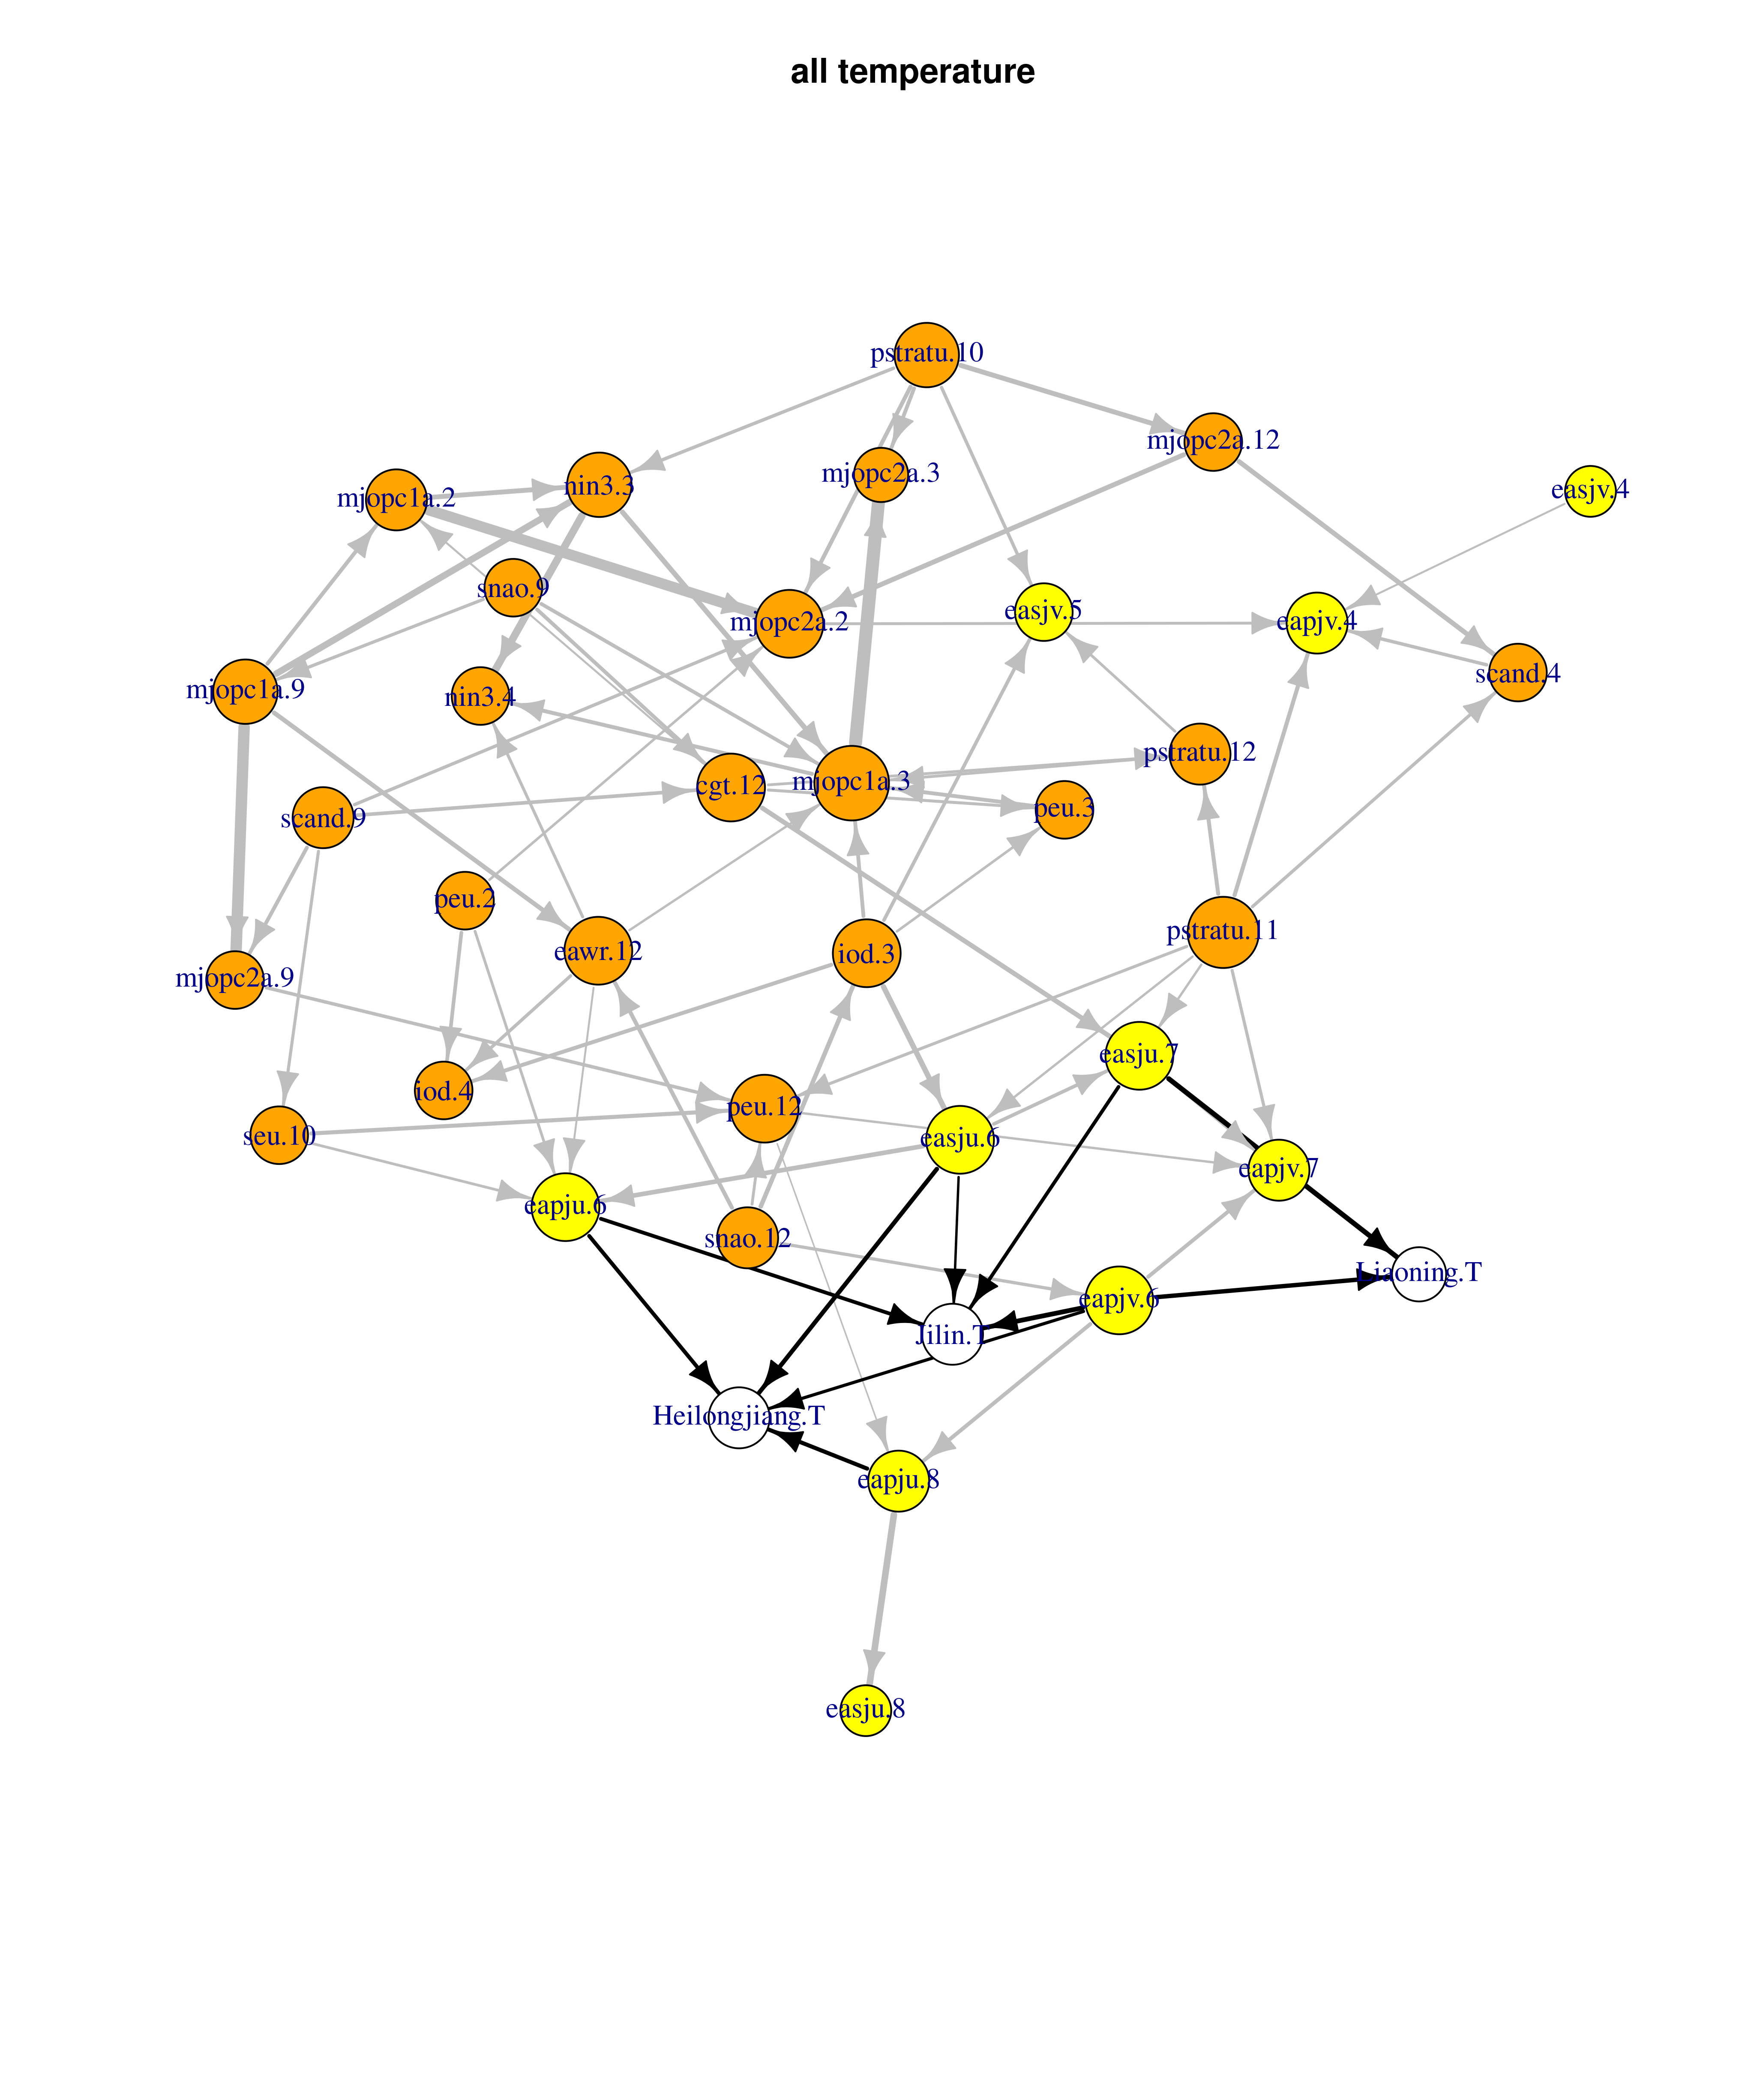

In [117]:
display_png(file=paste('./china_maize_network_',vname,'_jet_',ystrts,'_',yends,"_lag_",lag,"_",suffix,'.png', sep="")) 

# Section 5: Predictive models 

In [118]:
t_parent_all

[[1]]
[1] "snao.12"    "cgt.12"     "pstratu.11"

[[2]]
[1] "seu.10"     "eawr.12"    "peu.2"      "snao.12"    "iod.3"     
[6] "pstratu.11" "cgt.12"    

[[3]]
[1] "seu.10"     "eawr.12"    "peu.2"      "peu.12"     "snao.12"   
[6] "iod.3"      "pstratu.11"

In [133]:
automate_predict <- function(namex, ydata, xdata, xoos) {
  #    browser()
  xmat = as.matrix(xdata)
  df = data.frame(ydata, xdata)
  colnames(df) = c("Y", paste(namex,1:dim(xmat)[2], sep=""))
  form = as.formula(sprintf("Y ~ %s", paste(names(df)[2:length(names(df))], collapse = " + ")))
  
  model = lm(form, df)
  
  out_of_sample_data <- data.frame(t(xoos))
  cf <-coef(summary(model, complete = TRUE)) 
  colnames(out_of_sample_data) = rownames(cf)[-1]
  pred = predict(model, out_of_sample_data, se.fit = TRUE)$fit
  predict_effects = coef(model)[2:length(coef(model))]*t(out_of_sample_data)
  
  A=c()
  A$model = model
  A$pred = pred
  A$effects = predict_effects
  #    browser()
  return(A)  
}

create_empty_dataframe <- function(years, regions){
    empty_df = array(NA, c(length(years), length(regions)))
    rownames(empty_df) = years
    colnames(empty_df) = regions 
    return(empty_df)
}

In [140]:
t_loocv = create_empty_dataframe(rownames(temp_jja), regs)
t_loocv_rf = create_empty_dataframe(rownames(temp_jja), regs)
t_loocv_red = create_empty_dataframe(rownames(temp_jja), regs)

t_int = create_empty_dataframe(rownames(temp_jja), regs)
t_ent = create_empty_dataframe(rownames(temp_jja), regs)

t_abs_loocv = create_empty_dataframe(rownames(temp_jja), regs)
t_abs_loocv_rf = create_empty_dataframe(rownames(temp_jja), regs)

t_effcv = array(NA, c(length(years),length(regs), dim(cindex_df)[2]))
dimnames(t_effcv)[[3]] <- colnames(cindex_df)

In [142]:
require(randomForest)

Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin




In [143]:
years = 1:length(rownames(cindex_df))
for (k in 1:length(regs)) {
    # get the T and P indexs of significant varibles 
    t_inds = gsub("[[:punct:]]", "-", t_parent_all[[k]])
    #print(t_inds2a)
    t_inds = t_inds[which(abs(cor(cindex_df[, t_inds], temp_anoms[,k])) >= critical.r(length(temp_anoms[,k]), 0.2))]
    print(t_inds)
    
    for (y in 1:length(years)) {
        #print(y)
        rind = y
        tt = 1:length(temp_anoms[-rind,k]) 
        lmmodt = lm(temp_anoms[-rind,k] ~ tt)

        # get mean T/P for the missing year    
        ttout_of_sample_data <- data.frame(tt = t(rind))
        tmean_pred = predict(lmmodt, ttout_of_sample_data, se.fit = TRUE)$fit
        
        
        if (length(t_inds) > 0) {
            tmod = automate_predict("t", lmmodt$residuals, cindex_df[-rind,t_inds], cindex_df[rind,t_inds])
            tmod_fit = tmod$model$fitted.values
            t_loocv[y,k] = tmod$pred
            t_effcv[y,k,t_inds] = tmod$effects
            t_int[y,k] = tmod$model$coefficients[1]
            frac = abs(t_effcv[y,k,t_inds])/sum(abs(t_effcv[y,k,t_inds]))
            t_ent[y,k] = -1.0*sum(frac*log(frac))

            ## forecast using random forests      
            set.seed(2019)
            # fit the model
            if (length(t_inds) > 1) {
                fit_rft <- randomForest(x=cindex_df[-rind,t_inds], y=lmmodt$residuals)
                t_loocv_rf[y,k] <- predict(fit_rft, cindex_df[rind,t_inds])
            } else {
                t_loocv_rf[y,k] <- 0.0
            }
        }
        
        t_train = lmmodt$fitted.values + tmod_fit

        t_oos = tmean_pred + tmod$pred

        t_oos_rf = tmean_pred + t_loocv_rf[y,k]

        ## also save out absolute temp and rainfall      
        t_abs_loocv[y,k] = t_oos

        t_abs_loocv_rf[y,k] = t_oos_rf
    
    }
}

[1] "snao-12"    "cgt-12"     "pstratu-11"
[1] "eawr-12"    "peu-2"      "snao-12"    "iod-3"      "pstratu-11"
[6] "cgt-12"    
[1] "eawr-12"    "peu-2"      "snao-12"    "iod-3"      "pstratu-11"


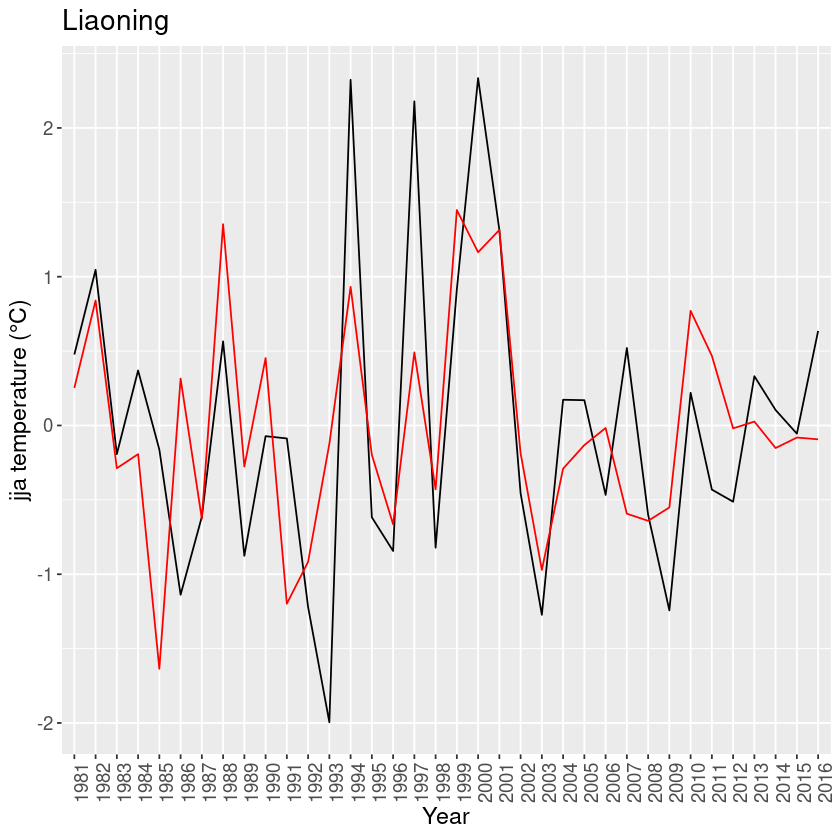

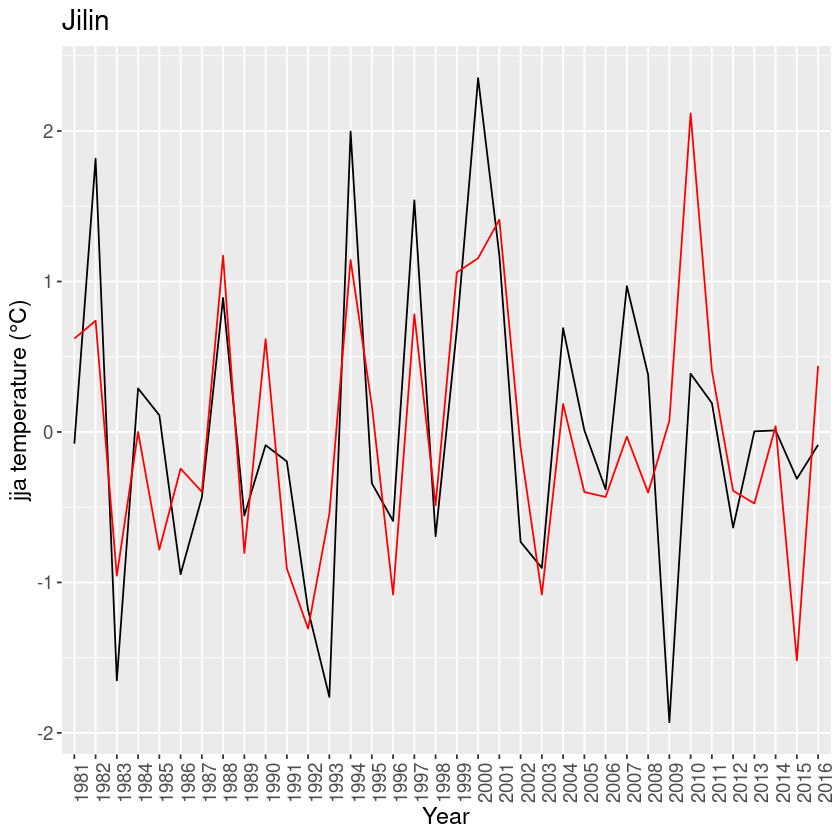

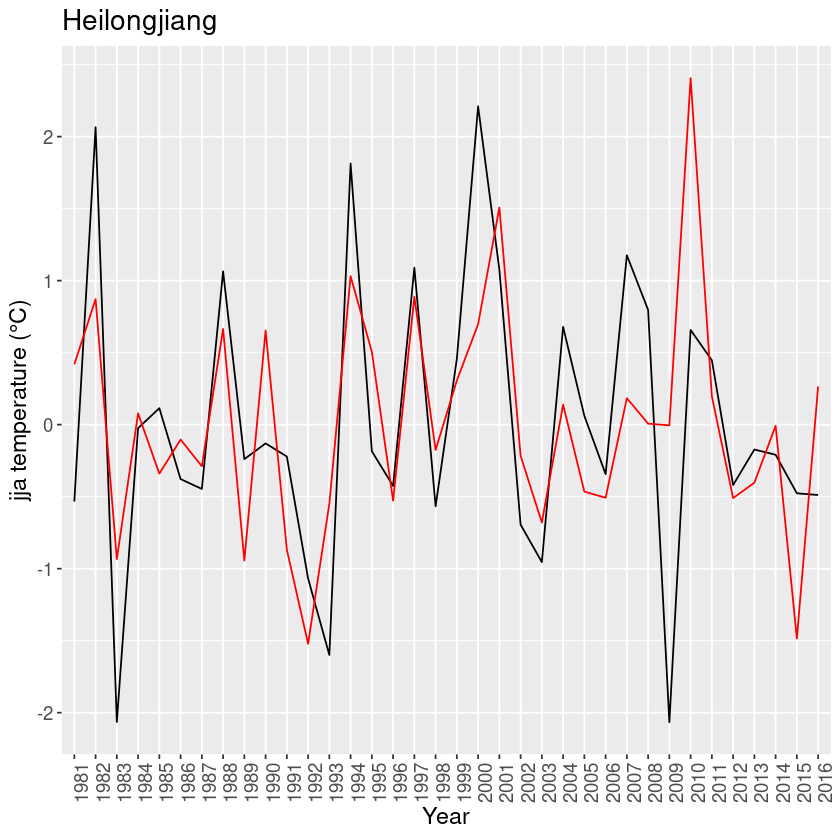

In [200]:
for (k in 1:length(regs)) {
    years <- rownames(temp_jja)
    obs <- temp_anoms[,k]
    result <- t_loocv[,k]
    df <- data.frame(years, obs, result)
    
    line_plot = ggplot(df, aes(x=years, group = 1)) +
    geom_line(aes(y=obs), color = "black") + 
    geom_line(aes( y=result), color = "red") + 
    ggtitle(regs[k]) + xlab("Year") + 
    ylab(paste(suffix," temperature (\u00B0C)",sep="")) +
    theme(axis.text.x = element_text(angle = 90)) +
    theme(text = element_text(size=14)) 
    
    print(line_plot)
    
}

In [147]:
create_df<-function(ind_effect, obs, yrs, monlist, indlist){
    v_inds = which(ind_effect[1,] != 0)
    vnames2 = names(v_inds)
    tt = 1:length(obs)
    lmmod = lm(obs ~ tt)
    year <- rep(yrs, each=length(v_inds))
    index <- rep(vnames2, times=length(yrs))
    value <- as.vector(t(ind_effect[,v_inds]))
    data <- data.frame(year,index,value)
    obs_resids = as.vector(lmmod$residuals)
    d2 <-data.frame(years, obs_resids)
    df <- data.frame(data)
    df$bar_heights <- rep(tapply(data$value, data$year, sum), each=length(v_inds))
    df$line_y <- rep(obs_resids,each=length(v_inds))

    return(df)
}

In [178]:
head(df_temp)

,year,index,value,bar_heights,line_y
,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,1981,iod-3,0.48984692,0.4071702,-0.5341211
2,1981,snao-12,-0.02927007,0.4071702,-0.5341211
3,1981,eawr-12,-0.05557399,0.4071702,-0.5341211
4,1981,peu-2,0.06768694,0.4071702,-0.5341211
5,1981,pstratu-11,-0.06551960,0.4071702,-0.5341211
6,1982,iod-3,0.45910658,0.8473857,2.0650803


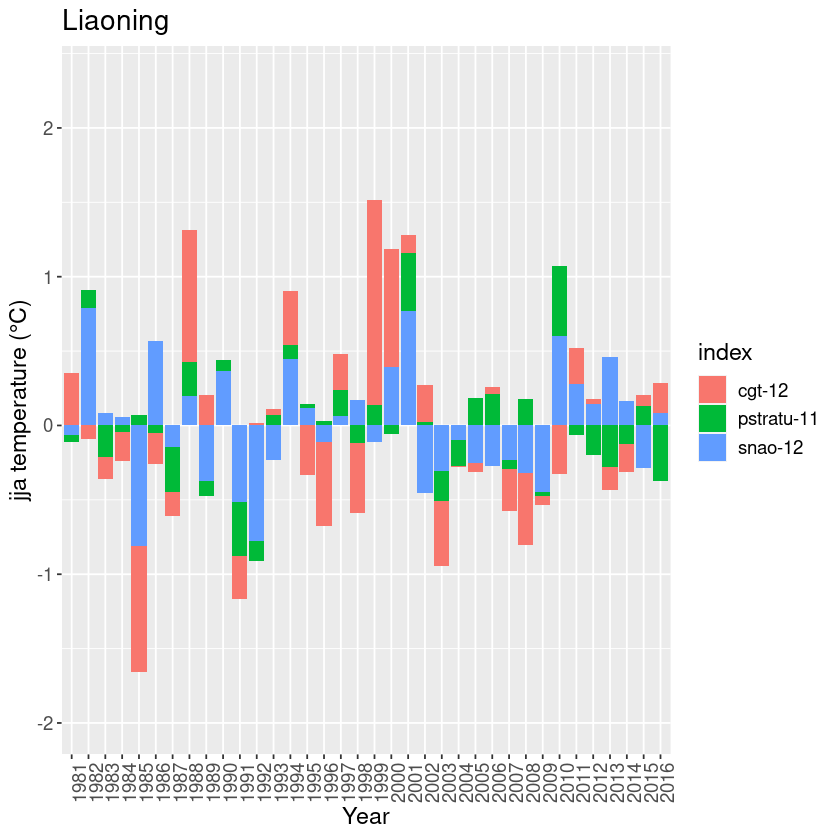

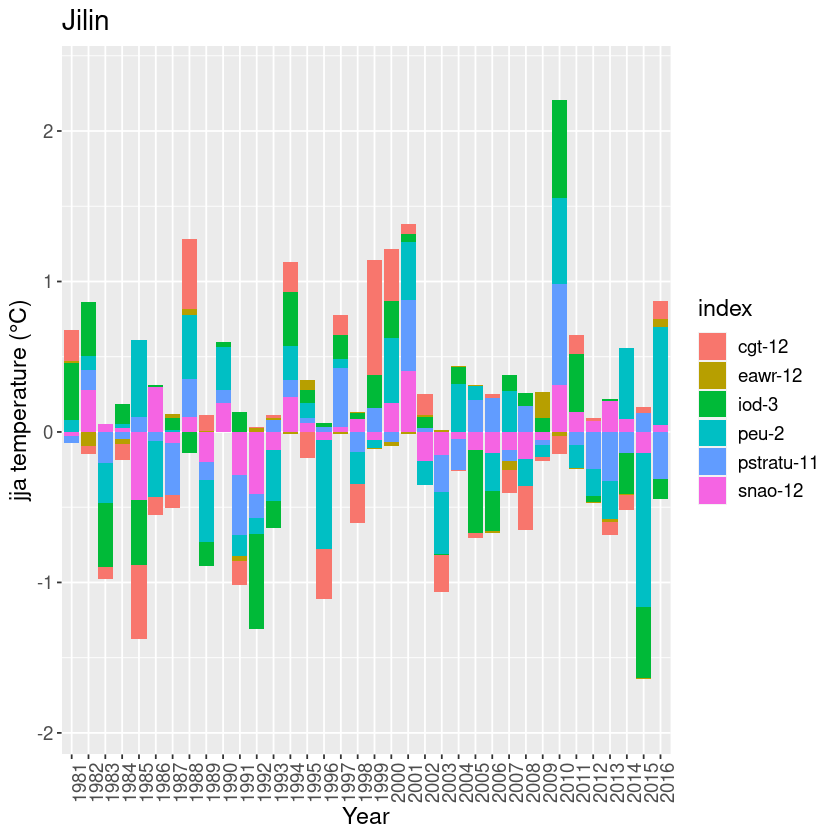

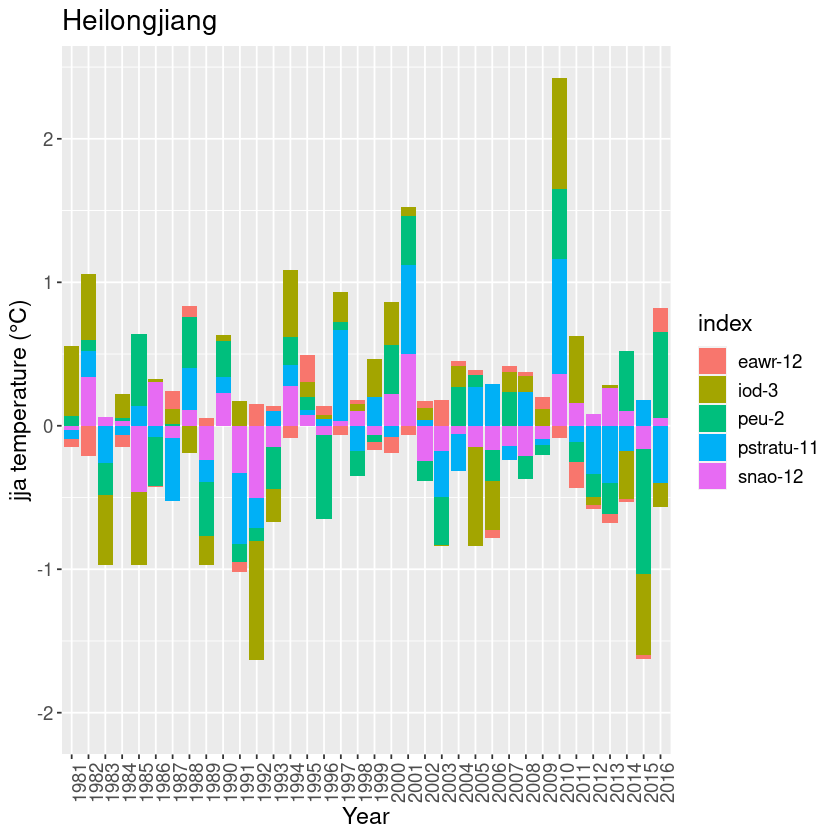

In [162]:
for (k in 1:length(regs)) {
    df_temp = create_df(t_effcv[,k,], temp_anoms[,k], rownames(temp_jja), mon_list, ind_list)
  # Stacked
  #  dev.new()
    #p <- ggplot(df_temp, aes(fill=index, y=value, x=year)) + 
      #  geom_bar(position="stack", stat="identity") + 
      #  geom_line(data = df_temp, aes(y=line_y, x=year)) +
      #  ggtitle(regs[k]) + xlab("Year") + 
      #  ylab(paste(suffix," temperature (\u00B0C)",sep="")) +
      #  theme(axis.text.x = element_text(angle = 90)) +
      #  theme(text = element_text(size=14)) 
    
    p <- ggplot(df_temp, aes(x=year)) + 
        geom_bar(aes(fill=index, y=value), position="stack", stat="identity") + 
        geom_line(aes(y=line_y)) +
        ggtitle(regs[k]) + xlab("Year") + 
        ylab(paste(suffix," temperature (\u00B0C)",sep="")) +
        theme(axis.text.x = element_text(angle = 90)) +
        theme(text = element_text(size=14)) 
    print(p)
    
}

### Bootstrapping confidence intervals 

In [202]:
library(boot)

In [203]:
function_1 <- function(data, i){
 d <- data[i,] 
 return(cor(d[,1], d[,2]))
}

In [204]:
liaoning_data = cbind(t_loocv[,'Liaoning'], temp_anoms[,'Liaoning-T'])
jilin_data = cbind(t_loocv[,'Jilin'], temp_anoms[,'Jilin-T'])
heilongjiang_data = cbind(t_loocv[,'Heilongjiang'], temp_anoms[,'Heilongjiang-T'])

#### Liaoning 

In [205]:
set.seed(1)
bootstrap_liaoning <- boot(liaoning_data,function_1,R=1000)
print(bootstrap_liaoning)
print(boot.ci(boot.out=bootstrap_liaoning))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = liaoning_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.6183284 0.002705394   0.0923039


Warning message in boot.ci(boot.out = bootstrap_liaoning):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_liaoning)

Intervals : 
Level      Normal              Basic         
95%   ( 0.4347,  0.7965 )   ( 0.4577,  0.8325 )  

Level     Percentile            BCa          
95%   ( 0.4042,  0.7790 )   ( 0.3689,  0.7638 )  
Calculations and Intervals on Original Scale


#### Jilin

In [206]:
set.seed(1)
bootstrap_Jilin <- boot(jilin_data,function_1,R=1000)
print(bootstrap_Jilin)
print(boot.ci(boot.out=bootstrap_Jilin))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = jilin_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original     bias    std. error
t1* 0.6562134 0.00837725  0.07921791


Warning message in boot.ci(boot.out = bootstrap_Jilin):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_Jilin)

Intervals : 
Level      Normal              Basic         
95%   ( 0.4926,  0.8031 )   ( 0.5085,  0.8132 )  

Level     Percentile            BCa          
95%   ( 0.4993,  0.8040 )   ( 0.3914,  0.7797 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable


#### Heilongjiang 

In [208]:
set.seed(1)
bootstrap_heilongjiang <- boot(heilongjiang_data,function_1,R=1000)
print(bootstrap_heilongjiang)
print(boot.ci(boot.out=bootstrap_heilongjiang))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = heilongjiang_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original    bias    std. error
t1* 0.6255919 0.0137258  0.07342574


Warning message in boot.ci(boot.out = bootstrap_heilongjiang):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_heilongjiang)

Intervals : 
Level      Normal              Basic         
95%   ( 0.4680,  0.7558 )   ( 0.4741,  0.7631 )  

Level     Percentile            BCa          
95%   ( 0.4881,  0.7770 )   ( 0.4184,  0.7458 )  
Calculations and Intervals on Original Scale
Some BCa intervals may be unstable


### Accessing dynamical Seasonal forecast from DePreSys

In [210]:
datadir = '../data/csv/DePreSys_NE_China_provinces_weighted_detrended_1981_2016.csv'
depresys = read.csv(datadir
         , header = TRUE,sep = ",", stringsAsFactors = FALSE) 

In [211]:
liaoning_data = cbind(depresys[,'Liaoning'], temp_anoms[,'Liaoning-T'])
jilin_data = cbind(depresys[,'Jilin'], temp_anoms[,'Jilin-T'])
heilongjiang_data = cbind(depresys[,'Heilongjiang'], temp_anoms[,'Heilongjiang-T'])

In [212]:
set.seed(1)
bootstrap_liaoning <- boot(liaoning_data,function_1,R=1000)
print(bootstrap_liaoning)
print(boot.ci(boot.out=bootstrap_liaoning))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = liaoning_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original      bias    std. error
t1* 0.2696603 0.007538836   0.1343295


Warning message in boot.ci(boot.out = bootstrap_liaoning):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_liaoning)

Intervals : 
Level      Normal              Basic         
95%   (-0.0012,  0.5254 )   ( 0.0085,  0.5352 )  

Level     Percentile            BCa          
95%   ( 0.0041,  0.5308 )   (-0.0387,  0.4985 )  
Calculations and Intervals on Original Scale


In [213]:
set.seed(1)
bootstrap_Jilin <- boot(jilin_data,function_1,R=1000)
print(bootstrap_Jilin)
print(boot.ci(boot.out=bootstrap_Jilin))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = jilin_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.2924243 -0.0006353441   0.1422674


Warning message in boot.ci(boot.out = bootstrap_Jilin):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_Jilin)

Intervals : 
Level      Normal              Basic         
95%   ( 0.0142,  0.5719 )   ( 0.0295,  0.5958 )  

Level     Percentile            BCa          
95%   (-0.0109,  0.5553 )   ( 0.0057,  0.5577 )  
Calculations and Intervals on Original Scale


In [214]:
set.seed(1)
bootstrap_heilongjiang <- boot(heilongjiang_data,function_1,R=1000)
print(bootstrap_heilongjiang)
print(boot.ci(boot.out=bootstrap_heilongjiang))


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = heilongjiang_data, statistic = function_1, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.2445439 0.0007686634   0.1668556


Warning message in boot.ci(boot.out = bootstrap_heilongjiang):
"bootstrap variances needed for studentized intervals"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bootstrap_heilongjiang)

Intervals : 
Level      Normal              Basic         
95%   (-0.0833,  0.5708 )   (-0.0734,  0.5648 )  

Level     Percentile            BCa          
95%   (-0.0757,  0.5625 )   (-0.0893,  0.5510 )  
Calculations and Intervals on Original Scale
